# Exploratory Data Analysis Project

## Environment preparations

*Warning! Uncomment choosen code*

### Google Colab

In [ ]:
# !pip3 install statsmodels ppscore

### Local (Probably others than Colab)

In [ ]:
# !pip3 install pandas matplotlib scikit-learn seaborn statsmodels numpy scipy statsmodels ppscore

## Code

### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ppscore as pps
import statsmodels.graphics.gofplots as sm

from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

from pandas import DataFrame
from statsmodels.regression.linear_model import RegressionResultsWrapper
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind


### Functions

In [ ]:
def plot_regression(
    df: DataFrame,
    fit_model: RegressionResultsWrapper,
    x_type: str,
    y_type: str
  ):

  # Create plots
  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  # Scatter plot
  axs[0, 0].scatter(df[x_type], df[y_type])
  axs[0, 0].scatter(df[x_type], fit_model.fittedvalues,
                    color='red', label='Regression')
  axs[0, 0].set_xlabel(x_type)
  axs[0, 0].set_ylabel(y_type)
  axs[0, 0].legend()

  # Residuals plot
  axs[0, 1].scatter(df[x_type], fit_model.resid)
  axs[0, 1].set_xlabel(x_type)
  axs[0, 1].set_ylabel('Residuals')

  # Residuals histogram
  axs[1, 0].hist(fit_model.resid, bins=20, edgecolor='black')
  axs[1, 0].set_xlabel('Residuals')
  axs[1, 0].set_ylabel('Frequency')

  # Q-Q plot
  stats.probplot(fit_model.resid, dist="norm", plot=axs[1, 1])
  axs[1, 1].set_title('Q-Q Plot')

  # Show plots
  plt.tight_layout()
  plt.show()


In [ ]:
def residual_analysis(df: DataFrame, x_type: str , y_type: str) -> RegressionResultsWrapper:
    model = ols(f'{y_type} ~ C({x_type})', data=df)
    estimation = model.fit()
    print(estimation.summary())
    plot_regression(df, estimation, x_type, y_type)
    return estimation


In [ ]:
def heatmap(df: DataFrame):
    df_encoded = df.copy()
    non_numeric_columns = df.select_dtypes(exclude=['number']).columns
    label_encoder = LabelEncoder()
    for column in non_numeric_columns:
        df_encoded[column] = label_encoder.fit_transform(df[column].astype(str))
    corrmat = df_encoded.corr()
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corrmat, vmax=.8, square=True)
    plt.show()


In [ ]:
def create_hypotesis(y: str, x:str, df: DataFrame, alpha: int = 0.05, a_val=1, b_val=0):
    a = df[df[x] == a_val][y]
    b = df[df[x] == b_val][y]

    # Perform a t-test
    t_statistic, p_value = ttest_ind(a, b)

    # Display the results
    print(f'Test A/B {x}')
    print(f'T-Statistic: {t_statistic}')
    print(f'P-Value: {p_value}')

    observed_difference = a.mean() - b.mean()

    # Check if the p-value is less than the significance level (e.g., 0.05)
    if p_value < alpha:
        print(f'There is a significant difference between {x} == {a_val} and {x} == {b_val}.')
        if observed_difference > 0:
            print(f"Group {x} == {a_val} is more effective than Group {x} == {b_val}")
        else:
            print(f"Group {x} == {b_val} is more effective than Group {x} == {a_val}.")
        print(f"by {abs(observed_difference)} mean. \n")
    else:
        print(f'There is no significant difference between {x} == 1 and {x} == 0. \n')


### Load data

In [ ]:
# Load Data
store_info: DataFrame = pd.read_csv('store.csv')
store_sales: DataFrame = pd.read_csv('store_data.csv')
store_states: DataFrame = pd.read_csv("store_states.csv")
state_names: DataFrame = pd.read_csv("state_names.csv")
weather: DataFrame = pd.read_csv("weather.csv")


C:\Users\elite\AppData\Local\Temp\ipykernel_14472\1445580369.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  store_sales: DataFrame = pd.read_csv('store_data.csv')


### Prepare data

In [ ]:
# Weather column name fix
weather.rename(columns={'file': 'StateName'}, inplace=True)


In [ ]:
# Merge usable data
soup_df = pd.merge(
    store_sales,
    store_info[['Store', 'StoreType', 'Assortment', 'CompetitionDistance']],
    on='Store', how='left')
soup_df = pd.merge(soup_df, store_states, on='Store', how='left')
soup_df = pd.merge(soup_df, state_names, on='State', how='left')
soup_df = pd.merge(
    soup_df,
    weather[['StateName', 'Date', 'Mean_TemperatureC', 'Precipitationmm', 'CloudCover', 'Events']],
    on=['StateName','Date'], how='left')


In [ ]:
# Split weather events to one-hot encoded weather types
events_one_hot_encoded = soup_df['Events'].str.get_dummies('-')
soup_df = pd.concat([soup_df, events_one_hot_encoded], axis=1)
soup_df = soup_df.drop(['Events'], axis=1)


In [ ]:
# Add cart value
soup_df['CartValue'] = soup_df['Sales'] / soup_df['Customers']
# Fix NaN if Customers are 0 in days off
soup_df['CartValue'] = soup_df['CartValue'].fillna(0)


In [ ]:
# Convert Promo and SchoolHoliday columns to booleans
boolean_factors = ['Promo', 'SchoolHoliday']
for factor in boolean_factors:
    soup_df[factor] = soup_df[factor].astype(bool)


In [ ]:
# Convert date from string to datetime type
soup_df['Date'] = pd.to_datetime(soup_df['Date'])


In [ ]:
# Month phases
# Yeah i know it's a little bit complicated but it fast :)
soup_df['MonthPhase'] = np.where(
    (soup_df['Date'].dt.day >= 1) & (soup_df['Date'].dt.day <= 10), 1,
    np.where((soup_df['Date'].dt.day >= 11) & (soup_df['Date'].dt.day <= 20), 2,3))


In [ ]:
# Add Month column to easier making seaborn plots
soup_df['Month'] = soup_df['Date'].dt.month

In [ ]:
# Get only rows when stores are open
soup_open_df = soup_df[soup_df['Open'] == 1]


In [ ]:
# Means prepared for first ols tests
soup_means_df = soup_df.groupby([
    'Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'State'
]).agg({'Sales': 'mean', 'Customers': 'mean', 'CartValue': 'mean'}).reset_index()
soup_means_df = soup_means_df.rename(columns={
    'Sales': 'MeanSales', 'Customers': 'MeanCustomers', 'CartValue': 'MeanCartValue'
})


In [ ]:
# Means prepared for A/B tests
soup_means_date_df = soup_df[soup_df['Open'] == 1]
soup_means_date_df = soup_means_date_df.groupby([
    'Date', 'Promo', 'SchoolHoliday', 'MonthPhase', 'Month', 'DayOfWeek', 'State'
]).agg({'Sales': 'mean', 'Customers': 'mean', 'CartValue': 'mean'}).reset_index()
soup_means_date_df = soup_means_date_df.rename(columns={
    'Sales': 'MeanSales', 'Customers': 'MeanCustomers', 'CartValue': 'MeanCartValue'
})


## General analysis

It is worth starting the analysis by analyzing the dependencies between all factors. This can be achieved by using a heatmap of all the dependencies taken into account

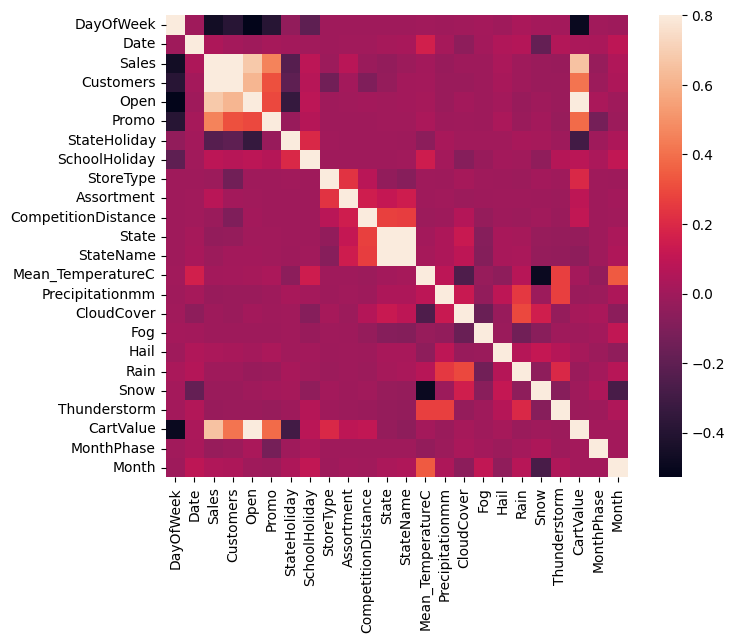

In [ ]:
heatmap(soup_df.drop(['Store'], axis=1))

From the initial examination of the heatmap, correlations between factors, including business and dependent factors, can be determined.
Based on this, the following correlations were identified between:
- opening (Open)
    - very strong positive (on closed store days, these factors are zero)
        - cart value
        - sales
        - customers quantity
    - very strong negative
        - days of the week (on some weekend days the store may be closed)
- public holidays (StateHoliday)
    - very strong positive (on closed store days, these factors are zero)
        - cart value
        - sales
        - customers quantity
- promotions (Promo)
    - strong positive
        - cart value
        - sales
        - customers quantity
    - positive
        - school holidays
- school holidays (SchoolHoliday)
    - positive
        - cart value
        - sales
        - customers quantity
        - promotions
- store type (StoreType)
    - strong positive
        - cart value
        - assortment type
    - positive
        - distance between stores
    - negative
        - customers quantity
        - state
- assortment (Assortment)
    - strong positive
        - cart value
        - state
        - distance between stores
    - positive
        - cart value
        - sales
- distance between stores (CompetitionDistance)
    - strong positive
        - state
        - assortment type
    - positive
        - store type
        - cart value
    - negative
        - number of customers
- state
    - strong positive
        - distance between stores
        - assortment
    - negative
        - store type
The performed analysis will make it easier to select factors for further analysis whose influence may be significant on business factors.

## Shop type influence analysis

### On sales

At first, it is worth checking with boxplots whether the factors are worth further analysis.
In order to reduce the time of generating the graphs, increase their readability and reduce the influence of date-dependent factors, a data set with averages for each of the stores (generated in the upper part of the code) was used.

<Axes: xlabel='StoreType', ylabel='MeanSales'>

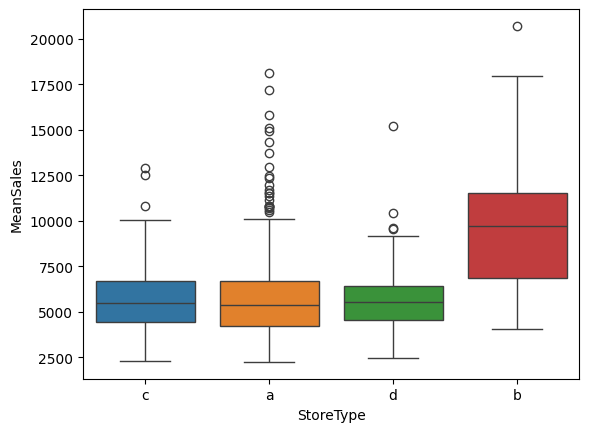

In [ ]:
sns.boxplot(x='StoreType', y='MeanSales', hue='StoreType', data=soup_means_df)

At first glance, you can see in relation to sales:
- significant dominance of type b stores with a greater deviation
- comparable results of the rest of the types of stores

                            OLS Regression Results                            
Dep. Variable:              MeanSales   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     26.52
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           1.44e-16
Time:                        00:11:09   Log-Likelihood:                -10017.
No. Observations:                1112   AIC:                         2.004e+04
Df Residuals:                    1108   BIC:                         2.006e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5730.5639     80.74

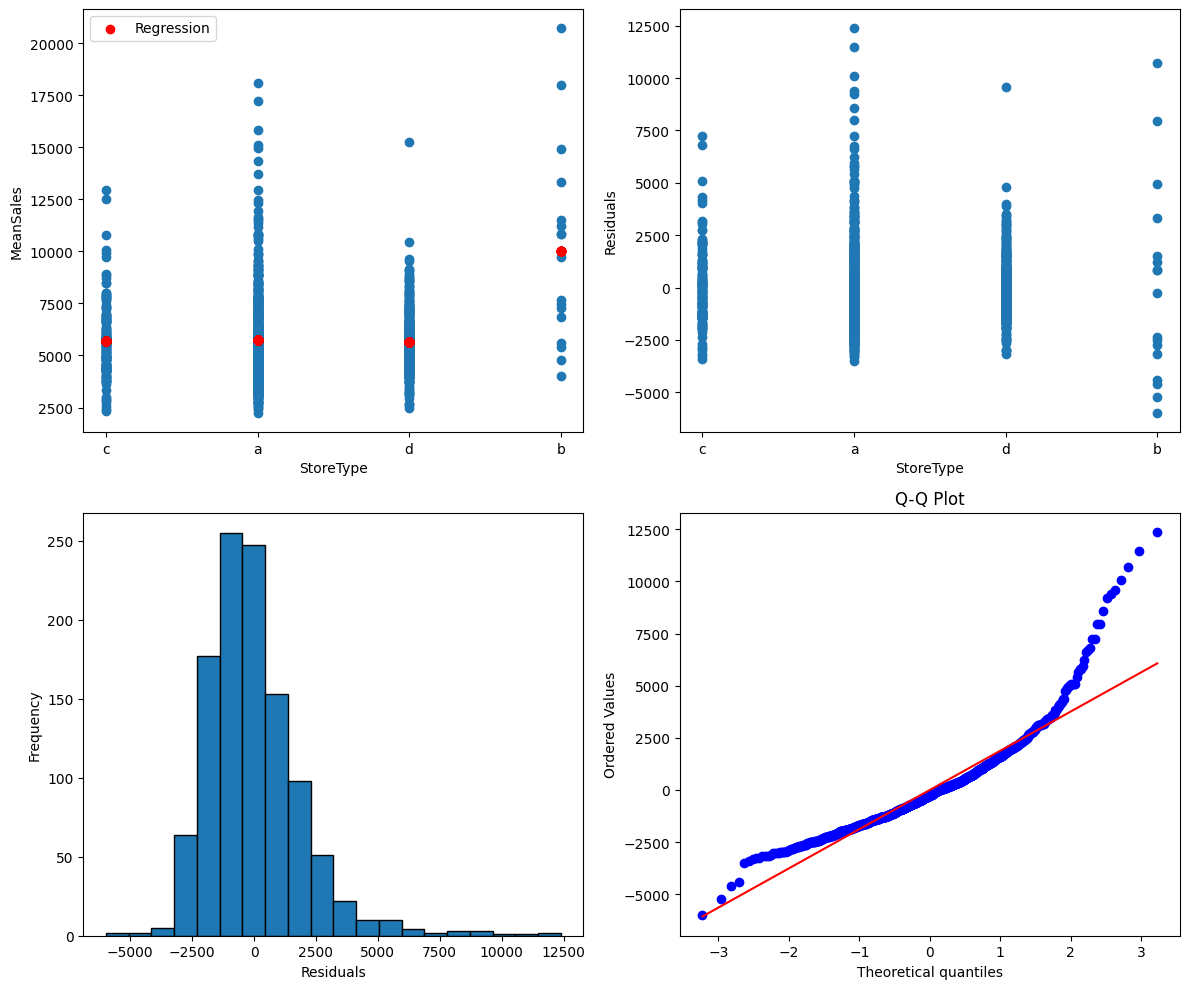

In [ ]:
residual_analysis(soup_means_df, 'StoreType', 'MeanSales')

Despite promising differences, the R-Squared coefficient itself did not reach high values, which translates into poor model reproduction.

An additional thing that can be noticed from the graphs is the density of the value of the type b store, which is quite small. Therefore, the number of stores of a specific type was analyzed:

In [3]:
for store_type in soup_means_df["StoreType"].unique():
    print(f'Quantity shops type {store_type}: {sum(soup_means_df["StoreType"] == store_type)}')

Quantity shops type c: 148
Quantity shops type a: 601
Quantity shops type d: 346
Quantity shops type b: 17


As can be seen from the above analysis of the number of stores:
- there are the most type d stores
- there are the fewest type b stores, several times less than all the others.

Due to the small number of type b stores, there may be a large value of deviations of this store in this and other comparisons.

### On customers quantity

<Axes: xlabel='StoreType', ylabel='MeanCustomers'>

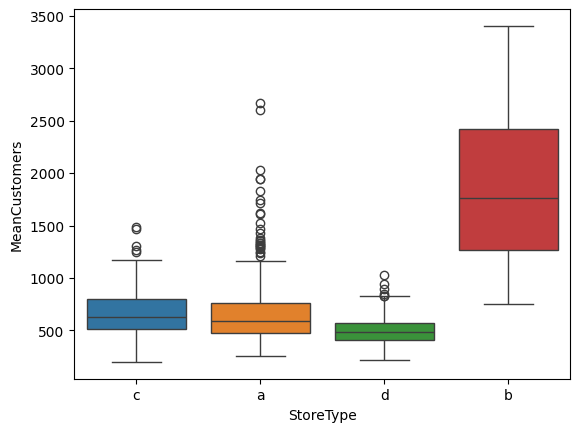

In [ ]:
sns.boxplot(x='StoreType', y='MeanCustomers', hue='StoreType', data=soup_means_df)

The boxplot analysis shows that
- type b stores attract the largest number of customers among all stores.
- type d stores are characterized by the smallest value, although slightly smaller than in the case of a and c.
- type a and c stores seem to be comparable.

                            OLS Regression Results                            
Dep. Variable:          MeanCustomers   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     183.7
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           1.09e-96
Time:                        00:11:10   Log-Likelihood:                -7762.8
No. Observations:                1112   AIC:                         1.553e+04
Df Residuals:                    1108   BIC:                         1.555e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           656.8416     10.63

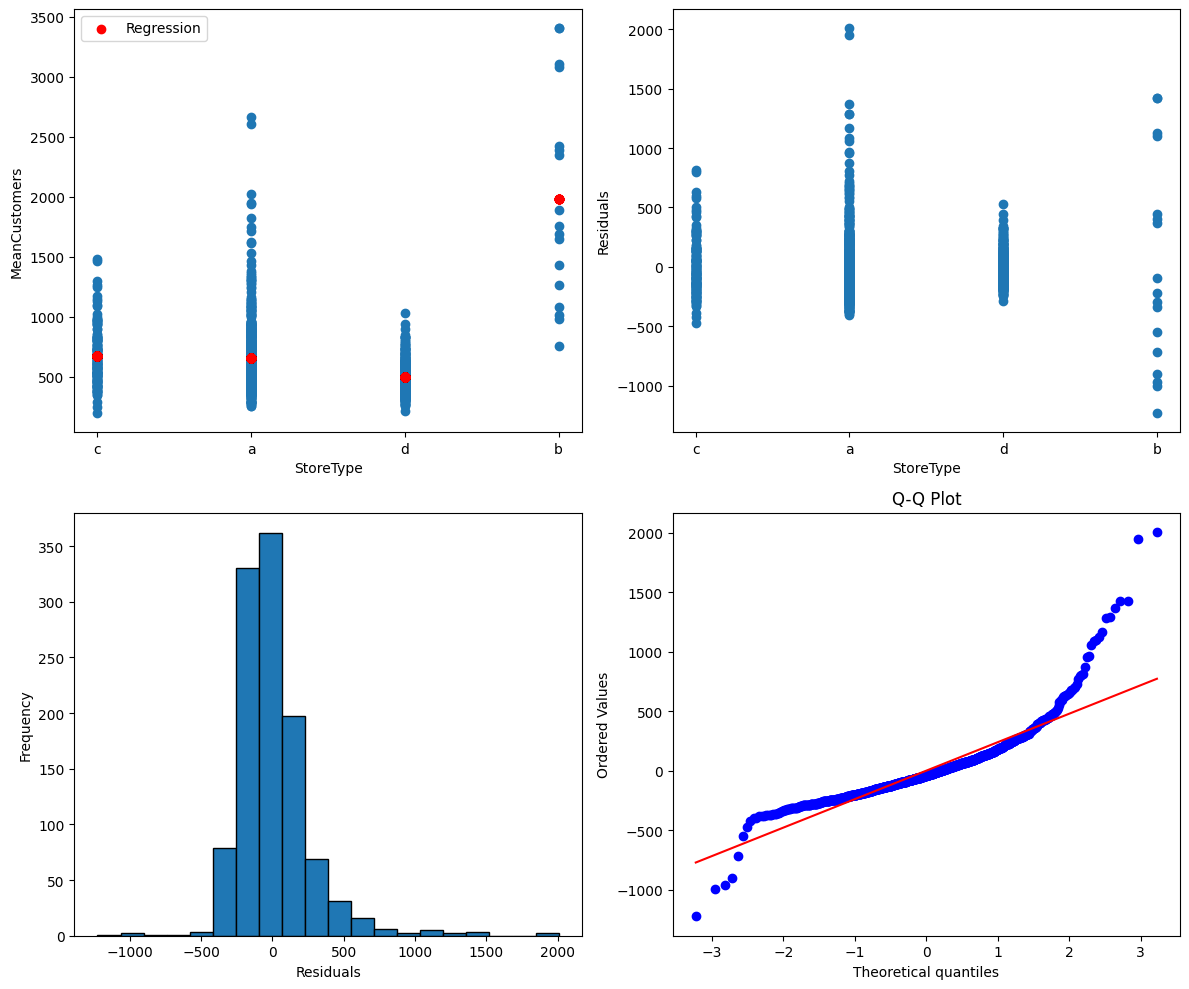

In [ ]:
residual_analysis(soup_means_df, 'StoreType', 'MeanCustomers')

The residual analysis allowed us to obtain quite a good representation of the model at the level of about 0.33 of the R-Squared value, and the representation line on the Q-Q plot more or less represents the middle part of the values.

### On cart value

<Axes: xlabel='StoreType', ylabel='MeanCartValue'>

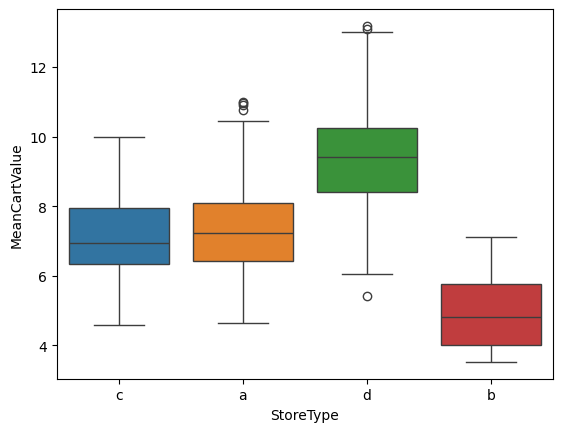

In [ ]:
sns.boxplot(x='StoreType', y='MeanCartValue', hue='StoreType', data=soup_means_df)

Analysis of the above boxplot allows us to conclude that:
- store type d achieves the highest cart value.
- store type b achieves the lowest cart value.
- stores type a and c are similar in this respect.

in this case, the deviations are similar for each type of store, which results from the fact that we obtained the quotient of the two previous coefficients. Which confirms the suggested solution to this problem.

                            OLS Regression Results                            
Dep. Variable:          MeanCartValue   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     250.5
Date:                Sat, 27 Jan 2024   Prob (F-statistic):          4.75e-124
Time:                        00:11:11   Log-Likelihood:                -1810.7
No. Observations:                1112   AIC:                             3629.
Df Residuals:                    1108   BIC:                             3649.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.3454      0.05

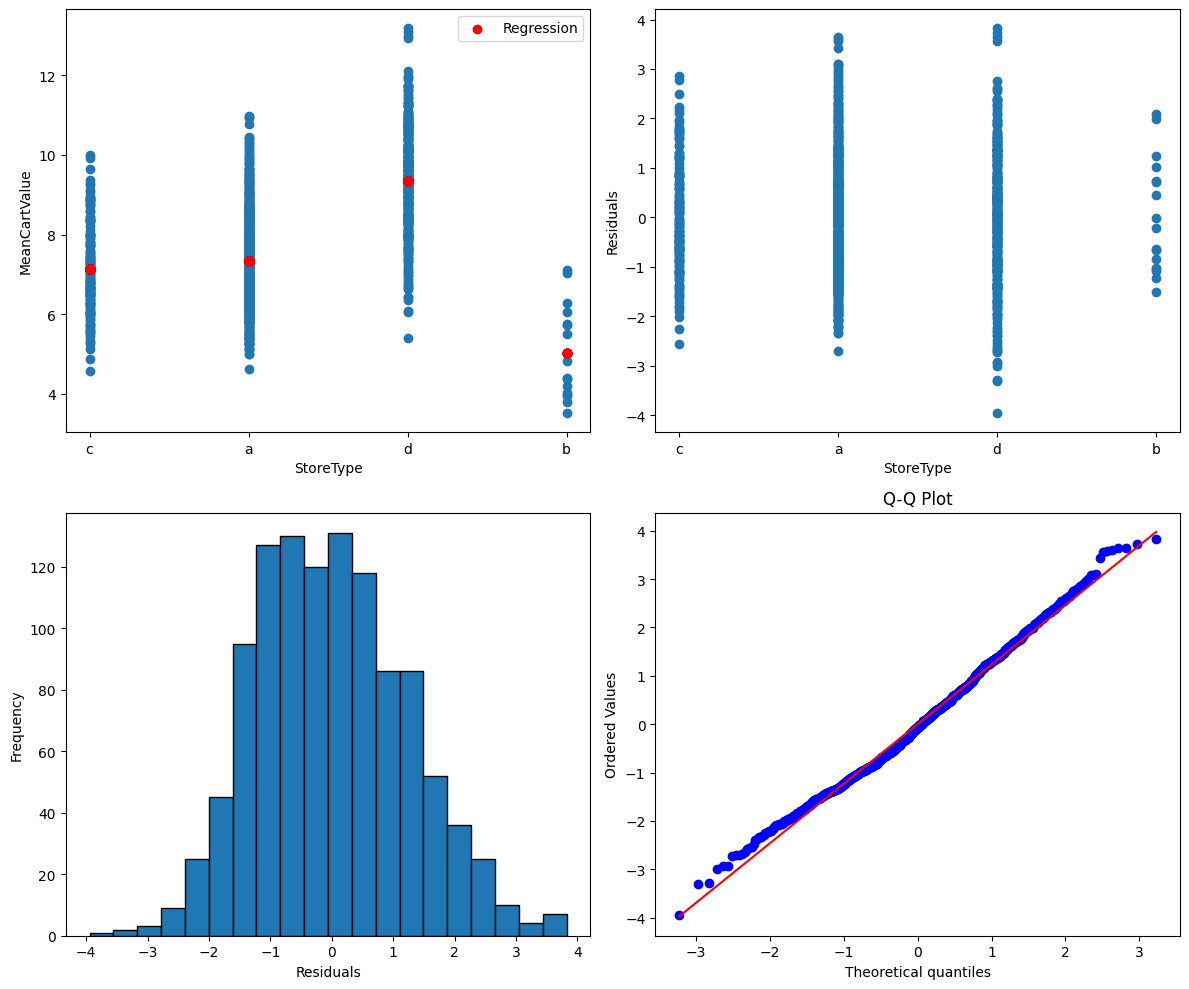

In [ ]:
residual_analysis(soup_means_df, 'StoreType', 'MeanCartValue')

The residual analysis allowed to obtain a good model representation at the level of about 0.4 of the R-Squared value. And the projection line on Q-Q coincides very well

### Summary

Summary of the influence of store type based on the analyses cited:
- Sales
    - store b generates the highest sales
    - stores a, c, d generate similar sales
- Customers
    - store b attracts the highest number of customers
    - store d attracts the lowest number of customers
    - stores a, c attract a similar number of customers
- Cart value
    - store d has the highest cart value
    - store b has the lowest cart value
    - stores a, c have an average and similar cart value

Additional research allowed us to conclude that the deviations in the values for type b stores result from the small number of these types of stores.

It is worth noting that the R-squared fit of the model for
- store type to sales obtains a result of 0.067
- store type to average customers quantity obtains a result of 0.33
- store type to average cart value obtains a result of 0.4

The obtained results may suggest that:
- store b is an experimental store that is introduced to the market in order to check whether it has its niche. It is probably also heavily promoted, which attracts a large number of customers, but the commission from the sale of products is low due to either cheap products or the sale of a small number of them.
- store d may be a luxury store that has more expensive products that do not attract a many customers, but they generate a high cart value and average sales.
- stores a and c are similar for each of these business values, so it is difficult to say anything specific about them at this point.

## Assortment type influence analysis

### On sales

<Axes: xlabel='Assortment', ylabel='MeanSales'>

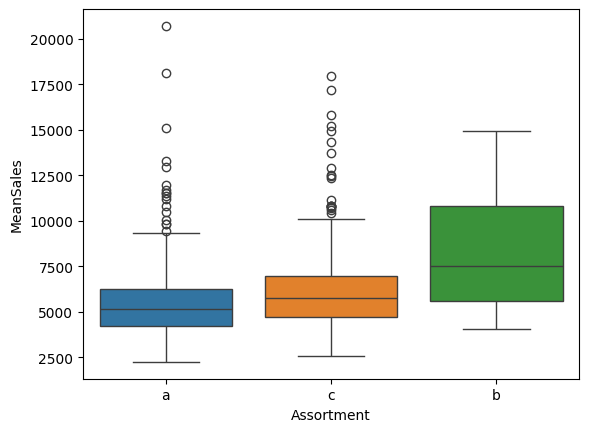

In [ ]:
sns.boxplot(x='Assortment', y='MeanSales', hue='Assortment', data=soup_means_df)

The analysis of the graph shows that:
- the store with assortment type b achieves the highest sales and has a very large deviation.
- the store with assortment type c achieves slightly higher sales than assortment a
- the store with assortment type a achieves the lowest sales

                            OLS Regression Results                            
Dep. Variable:              MeanSales   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     20.11
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           2.64e-09
Time:                        00:11:12   Log-Likelihood:                -10035.
No. Observations:                1112   AIC:                         2.008e+04
Df Residuals:                    1109   BIC:                         2.009e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           5470.4920     82

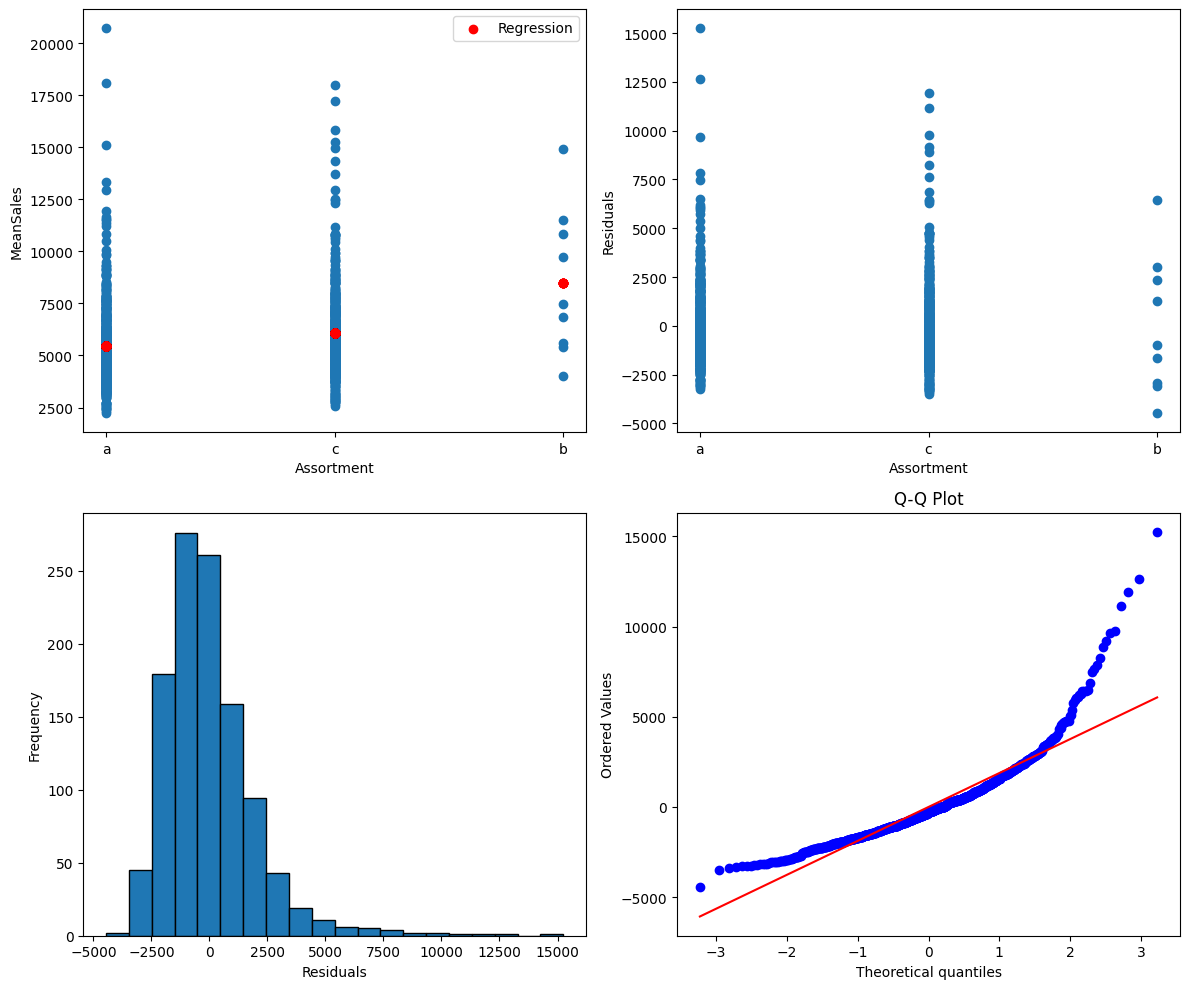

In [ ]:
residual_analysis(soup_means_df, 'Assortment', 'MeanSales')

Ols achieved an R-Squared value of 0.035. The model line only coincides in the middle part with sorted values.

Again, we can see a similar relationship with the amount of a given factor as in the previous case, so I will perform a quantitative analysis again.

In [5]:
for assortment in soup_means_df["Assortment"].unique():
    print(f'Quantity assortment type {assortment}: {sum(soup_means_df["Assortment"] == assortment)}')

Quantity assortment type a: 591
Quantity assortment type c: 512
Quantity assortment type b: 9


Conclusions
- Type b assortment is only available in a few stores
- Type a, c assortment is in similar proportions

### On customers quantity

<Axes: xlabel='Assortment', ylabel='MeanCustomers'>

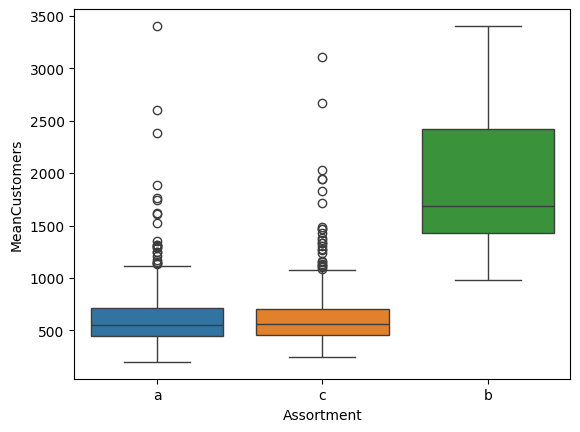

In [ ]:
sns.boxplot(x='Assortment', y='MeanCustomers', hue='Assortment', data=soup_means_df)

The boxplot analysis shows:
- stores with assortment b attract a more customers than those with assortment a and c
- stores with assortment a and c achieve similar results

                            OLS Regression Results                            
Dep. Variable:          MeanCustomers   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           5.24e-42
Time:                        00:11:13   Log-Likelihood:                -7892.0
No. Observations:                1112   AIC:                         1.579e+04
Df Residuals:                    1109   BIC:                         1.581e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            615.5867     12

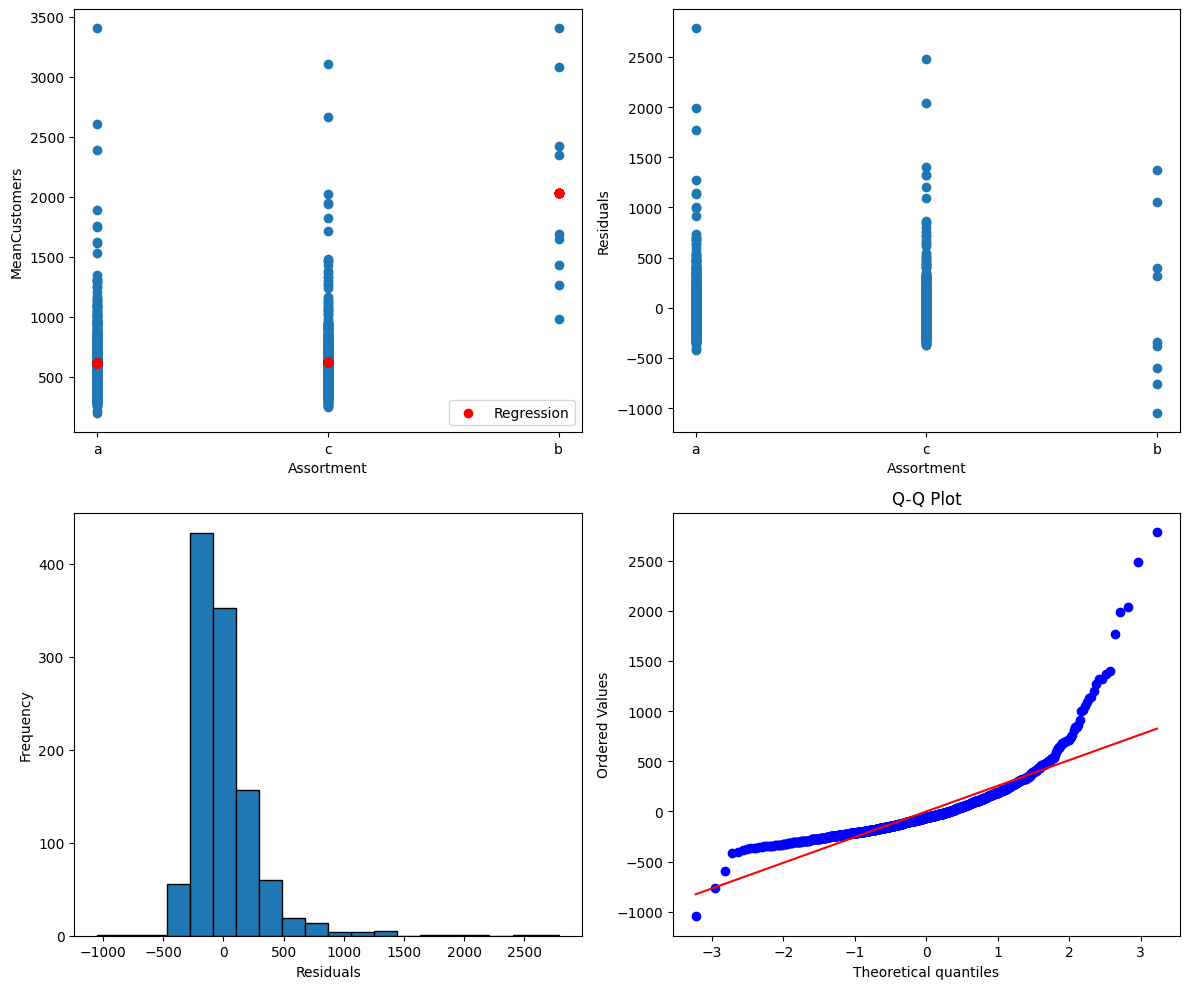

In [ ]:
residual_analysis(soup_means_df, 'Assortment', 'MeanCustomers')

OLS analysis allowed us to establish the R-Squared result at the level of 0.158, and the Q-Q plot overlaps only in the middle range of values.

### On cart value

<Axes: xlabel='Assortment', ylabel='MeanCartValue'>

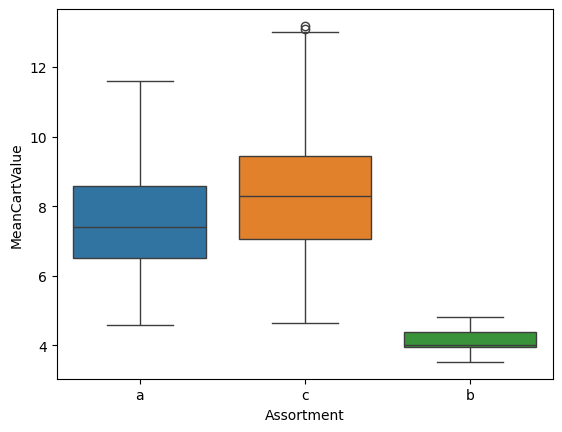

In [ ]:
sns.boxplot(x='Assortment', y='MeanCartValue', hue='Assortment', data=soup_means_df)

Boxplot analysis:
- Stores with assortment type c achieved the highest cart value
- Stores with assortment type a achieved a slightly lower cart value
- Stores with assortment type b achieved the lowest cart value and the lowest deviation

                            OLS Regression Results                            
Dep. Variable:          MeanCartValue   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     62.51
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           1.88e-26
Time:                        00:11:14   Log-Likelihood:                -2039.1
No. Observations:                1112   AIC:                             4084.
Df Residuals:                    1109   BIC:                             4099.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5879      0

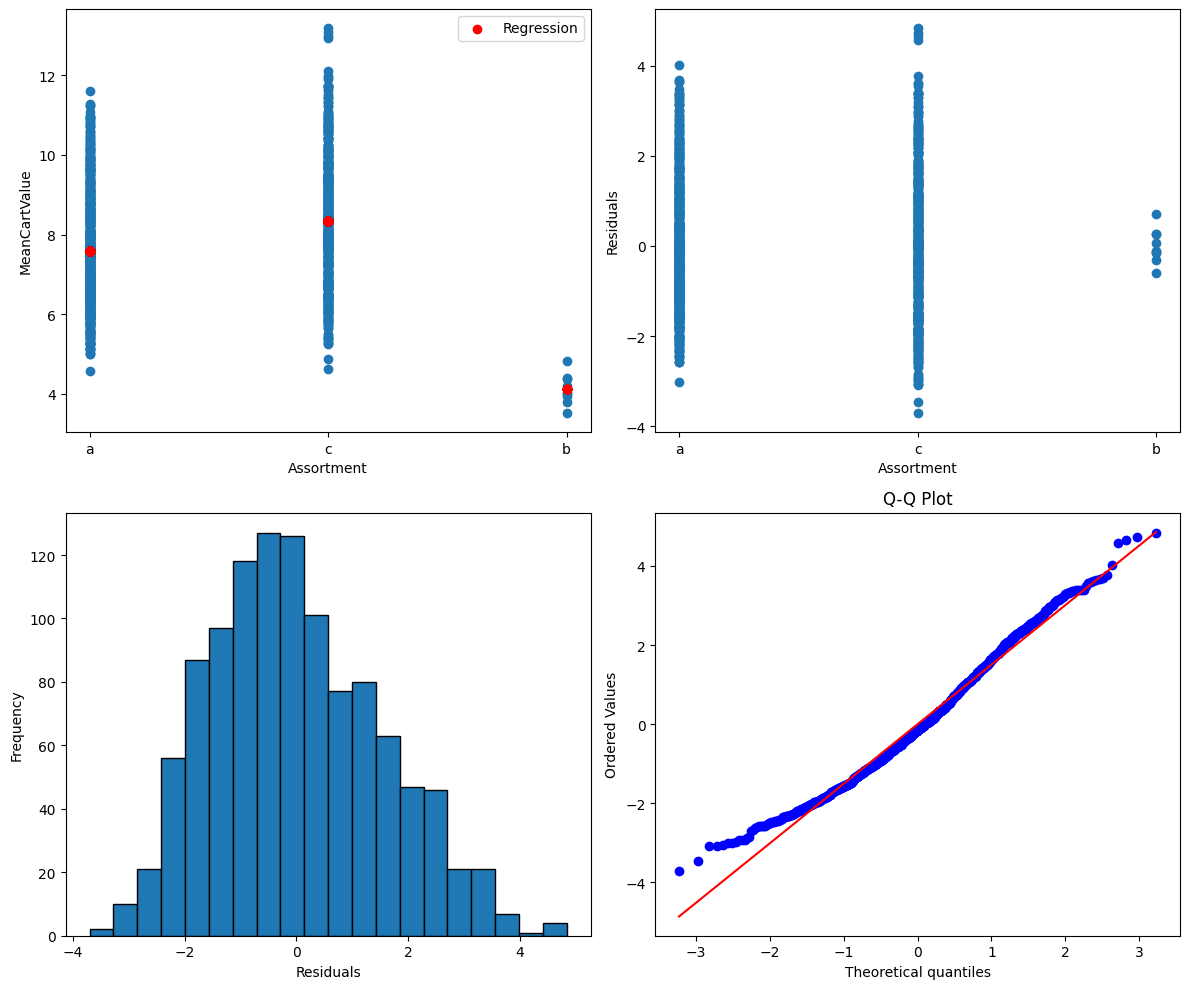

In [ ]:
residual_analysis(soup_means_df, 'Assortment', 'MeanCartValue')

The OLS analysis achieved a model representation of 0.101 R-Squared and even a well-represented Q-Q plot except for the lower range of values

### Summary

Assortment influence conclusions
- Sales
    - assortment b generates significantly higher sales than a/c
    - assortment c generates slightly higher sales than a
- Customers
    - assortment a, c attract customers at a similar level
    - assortment b attracts significantly more customers than a, c
- Cart value
    - assortment c generates the highest cart value
    - assortment a generates a lower cart value than assortment c
    - assortment b generates the lowest cart value regardless of the assortment type

Common conclusions:
- assortment type c probably has a higher commission than assortment type a, which is why it generates higher sales than a and at the same time its target group is of similar size.
- assortment type b probably attracts a large number of customers to the store but has a low price, which is why the cart value is low. Its sales is high only due to the large number of customers.

### Check dependency between store type and assortment

According to the heatmap, the type of product and the type of store seem to be dependent on each other. Therefore, in this section they will be compared.

<Axes: xlabel='StoreType', ylabel='MeanSales'>

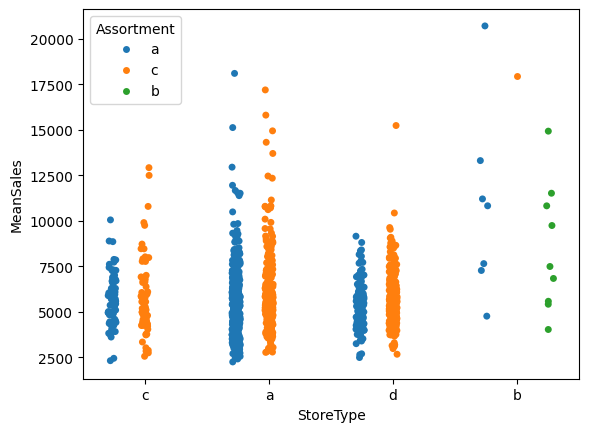

In [ ]:
sns.stripplot(x="StoreType", y="MeanSales", hue="Assortment", dodge=True, data=soup_means_df)


As you can see in the above chart, it seems that only store b has products of type b, which is something to check.

In [7]:
condition = (soup_means_df[soup_means_df['StoreType'] != 'b']['Assortment'] == 'b').sum()
print(f'Stores quantity with not type b and with b assortment: {condition}')

Stores quantity with not type b and with b assortment: 0


### Check B Stores assortments:

In [9]:
for assortment in soup_means_df['Assortment'].unique():
    stores_types = (soup_means_df[soup_means_df['StoreType'] == 'b']['Assortment'] == assortment).sum()
    print(f'B stores quantity with assortment {assortment}: {stores_types}')

B stores quantity with assortment a: 7
B stores quantity with assortment c: 1
B stores quantity with assortment b: 9


<Axes: xlabel='StoreType', ylabel='MeanSales'>

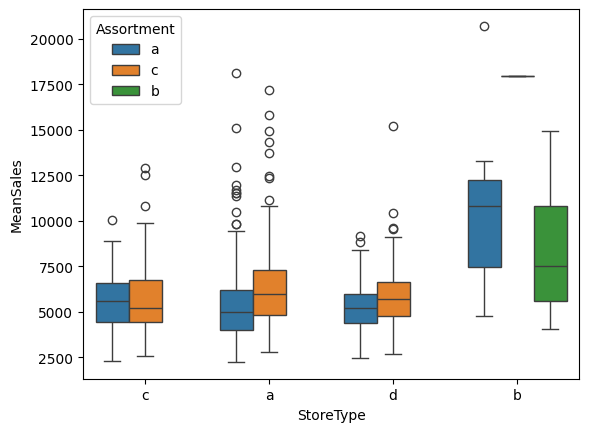

In [ ]:
sns.boxplot(x="StoreType", y="MeanSales", hue="Assortment", dodge=True, data=soup_means_df)

Conclusions:
- only type b stores have type b assortment
- type b stores can have a/b/c assortment
- type b stores have large price deviations (excluding type c otliner)
- type b stores with type b assortment generate lower sales than those with type a and c assortment.
- there is only one type b store with c assortment and it generates high sales.
- stores a, c, d can have a or c assortment
- type a and d stores have higher sales when they have a type c assortment
- type c stores have higher sales when they have a type a assortment

<Axes: xlabel='StoreType', ylabel='MeanCustomers'>

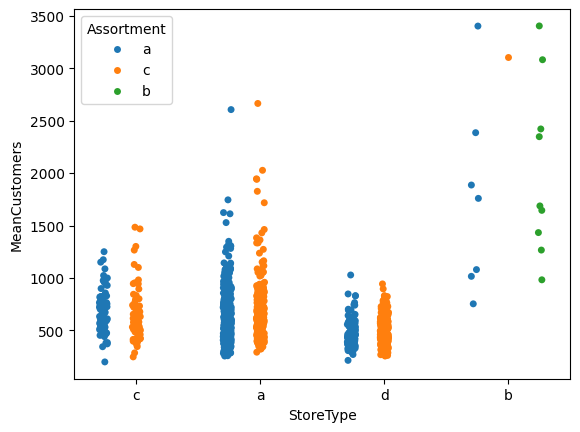

In [ ]:
sns.stripplot(x="StoreType", y="MeanCustomers", hue="Assortment", dodge=True, data=soup_means_df)

<Axes: xlabel='StoreType', ylabel='MeanCustomers'>

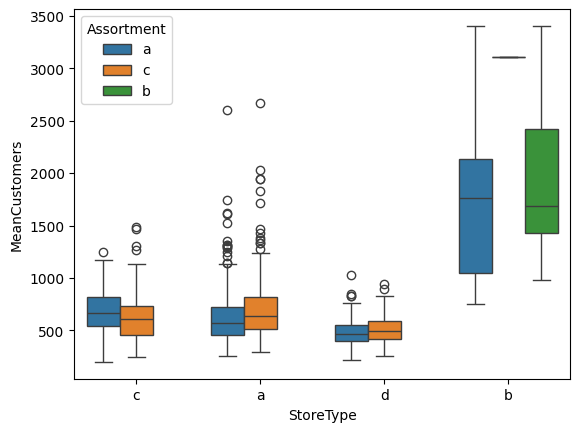

In [ ]:
sns.boxplot(x="StoreType", y="MeanCustomers", hue="Assortment", dodge=True, data=soup_means_df)

In the case of the dependence of attracting customers to the type of store depending on the assortment, we see the same dependence as in the case of generated sales to the type of store depending on the assortment

<Axes: xlabel='StoreType', ylabel='MeanCartValue'>

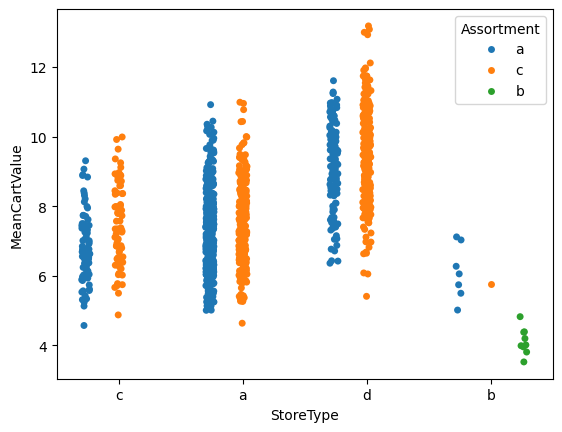

In [ ]:
sns.stripplot(x="StoreType", y="MeanCartValue", hue="Assortment", dodge=True, data=soup_means_df)

<Axes: xlabel='StoreType', ylabel='MeanCartValue'>

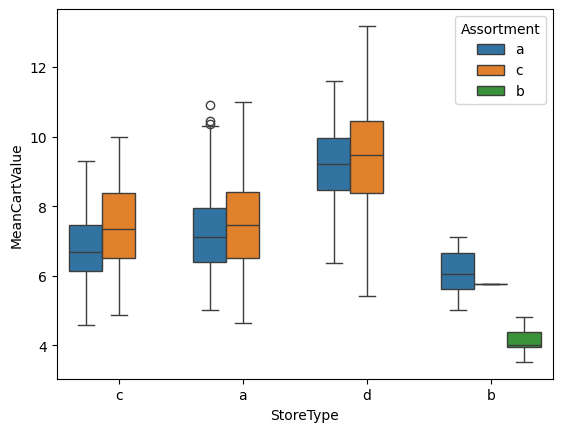

In [ ]:
sns.boxplot(x="StoreType", y="MeanCartValue", hue="Assortment", dodge=True, data=soup_means_df)

As can be seen in the above boxplot
    - stores of type a, c, d which have assortment of type c obtain higher value than those with assortment of type a

<Axes: xlabel='Assortment', ylabel='MeanCartValue'>

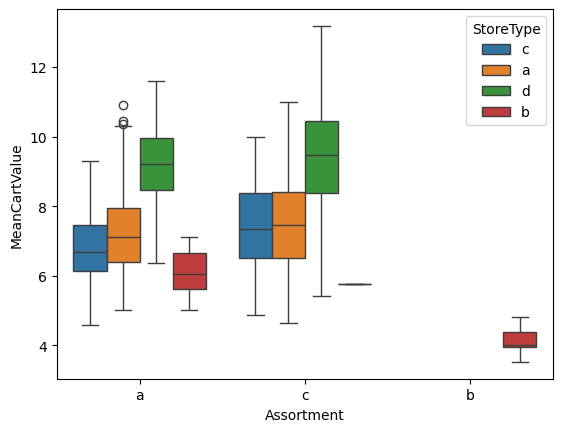

In [ ]:
sns.boxplot(x="Assortment", y="MeanCartValue", hue="StoreType", dodge=True, data=soup_means_df)

Conclusions
- in all stores, the type of assortment has an influence on cart value
- stores with type c assortment generate a higher cart value in all types of stores (except for the outliner in the form of a type b store)

### Summary based on store type and assortment

- store type b attracts the most customers and generates the highest sales regardless of the assortment.
- assortment type b reduces the cart value in store type b the most due to its low price and thus commission, which is why its sales compared to other types of assortments is small.
- assortment c generates the best cart value regardless of the store (we omit one outliner in store type b)
- in store types a, d assortment c generates higher sales but also attracts more customers
- in store type c assortment a generates higher sales but also attracts more customers

The obtained results may suggest that:
- type b assortment was created to promote type b stores, which would explain its presence only in type b stores and the low price and commission.
- type b stores are popular regardless of the assortment, but the price of their products is much lower than in other stores. They try to maintain the number of customers and not the high commission on products.
- type c assortment is more expensive, but in the case of type a, d stores it is more popular and thus generates greater sales for these types of stores
- store d has a higher commission on the same as a, which attracts fewer customers but generates a higher cart value.
- type a assortment is cheaper, but in the case of type c stores it is more popular and thus generates greater turnover for this type of store

Current suggestions for the store and assortment
- for the store type
    - stores a - a store for a poorer consumer, more willing to buy low-end but cheaper products
    - stores d - a new store wanting to attract as many customers as possible, offering new products as well as old ones at a low price
    - stores c - a store for an average consumer, more willing to buy mid-range products at reasonable prices
    - stores d - a store for a wealthy consumer willing to pay more for mid-range products
- for the assortment
    - assortment a - low-end products
    - assortment b - cheap new products with a low commission
    - assortment c - mid-range products

## Special offers influence analysis

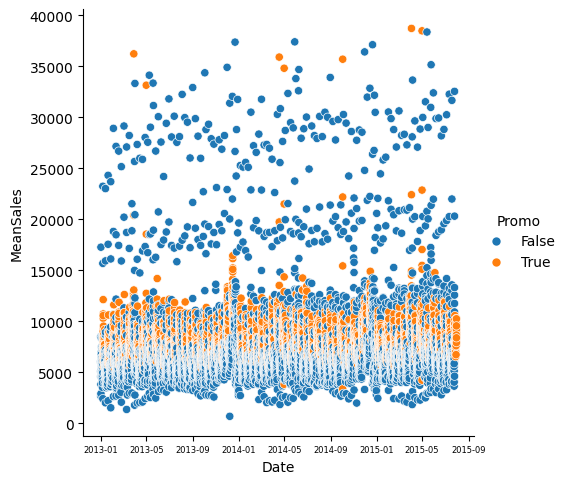

In [ ]:
g = sns.relplot(x='Date', y='MeanSales', hue='Promo', data=soup_means_date_df)
ax = g.axes[0, 0]
ax.tick_params(axis='x', labelsize=6)

At first glance, promotions increase sales in stores

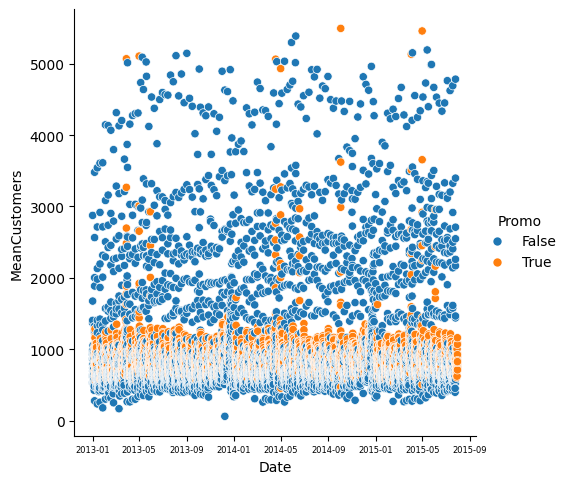

In [ ]:
g = sns.relplot(x='Date', y='MeanCustomers', hue='Promo', data=soup_means_date_df)
ax = g.axes[0, 0]
ax.tick_params(axis='x', labelsize=6)

They also increase the number of customers in stores.

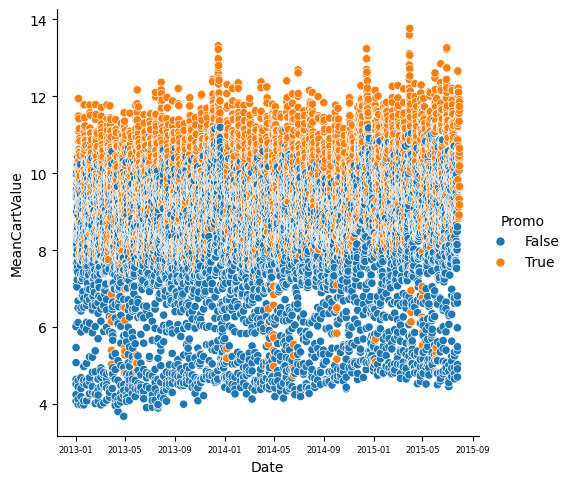

In [ ]:
g = sns.relplot(x='Date', y='MeanCartValue', hue='Promo', data=soup_means_date_df)
ax = g.axes[0, 0]
ax.tick_params(axis='x', labelsize=6)

and surprisingly, they also increase the average cart value, which either indicates a greater willingness to buy products, or it is a promotion on the principle of "buy 3 for the price of 2", or this promotion increases the value of these products

In [ ]:
# A/B test on whole data
create_hypotesis('Sales', 'Promo', soup_open_df)
create_hypotesis('Customers', 'Promo', soup_open_df)
create_hypotesis('CartValue', 'Promo', soup_open_df)

Test A/B Promo
T-Statistic: 363.8446754265649
P-Value: 0.0
There is a significant difference between Promo == 1 and Promo == 0.
Group Promo == 1 is more effective than Group Promo == 0
by 2298.8736358994774 mean. 

Test A/B Promo
T-Statistic: 170.89944194816303
P-Value: 0.0
There is a significant difference between Promo == 1 and Promo == 0.
Group Promo == 1 is more effective than Group Promo == 0
by 147.57751452583386 mean. 

Test A/B Promo
T-Statistic: 267.8930803790851
P-Value: 0.0
There is a significant difference between Promo == 1 and Promo == 0.
Group Promo == 1 is more effective than Group Promo == 0
by 1.2378972024046444 mean. 



Promotion (Promo) significantly affects the increase in sales, customers quantity and cart value, as evidenced by the above graphs for averages and A/B tests.

According to the heatmap, the promotion seems to be independent of store type and assortment, therefore this cross-factor analysis will be omitted.

## School-free days influence analysis

<Axes: xlabel='SchoolHoliday', ylabel='MeanSales'>

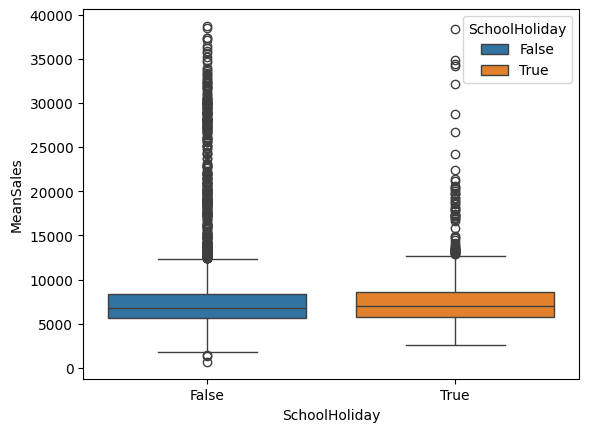

In [ ]:
sns.boxplot(x='SchoolHoliday', y='MeanSales', hue='SchoolHoliday', data=soup_means_date_df)

<Axes: xlabel='SchoolHoliday', ylabel='MeanCustomers'>

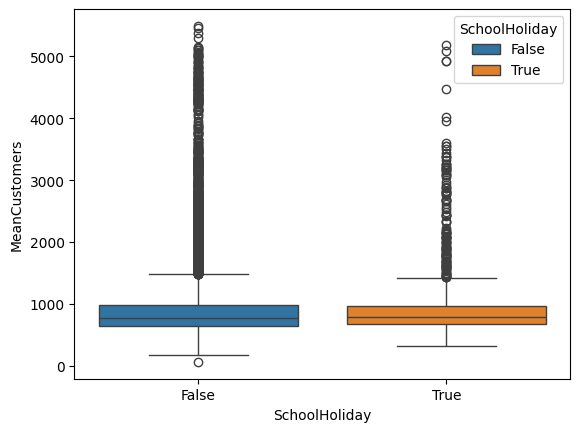

In [ ]:
sns.boxplot(x='SchoolHoliday', y='MeanCustomers', hue='SchoolHoliday', data=soup_means_date_df)

<Axes: xlabel='SchoolHoliday', ylabel='MeanCartValue'>

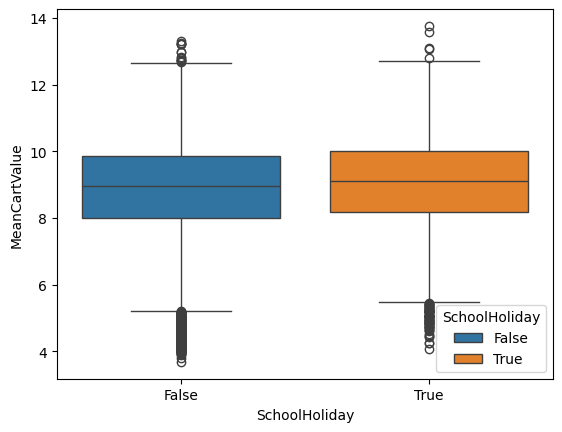

In [ ]:
sns.boxplot(x='SchoolHoliday', y='MeanCartValue', hue='SchoolHoliday', data=soup_means_date_df)

In [ ]:
# A/B test on whole data
create_hypotesis('Sales', 'SchoolHoliday', soup_open_df)
create_hypotesis('Customers', 'SchoolHoliday', soup_open_df)
create_hypotesis('CartValue', 'SchoolHoliday', soup_open_df)

Test A/B SchoolHoliday
T-Statistic: 35.51150492483466
P-Value: 5.231367176322406e-276
There is a significant difference between SchoolHoliday == 1 and SchoolHoliday == 0.
Group SchoolHoliday == 1 is more effective than Group SchoolHoliday == 0
by 303.39923927028485 mean. 

Test A/B SchoolHoliday
T-Statistic: 22.889650797868267
P-Value: 6.391626315180636e-116
There is a significant difference between SchoolHoliday == 1 and SchoolHoliday == 0.
Group SchoolHoliday == 1 is more effective than Group SchoolHoliday == 0
by 25.287917914752143 mean. 

Test A/B SchoolHoliday
T-Statistic: 12.09244372516493
P-Value: 1.1653588832205113e-33
There is a significant difference between SchoolHoliday == 1 and SchoolHoliday == 0.
Group SchoolHoliday == 1 is more effective than Group SchoolHoliday == 0
by 0.07322477118747628 mean. 



School holidays affect sales, customers quantity and cart value, as proven by A/B tests. Despite this, the difference is so small that it is not worth considering when creating a model.

## Days of the week influence analysis

<Axes: xlabel='DayOfWeek', ylabel='MeanSales'>

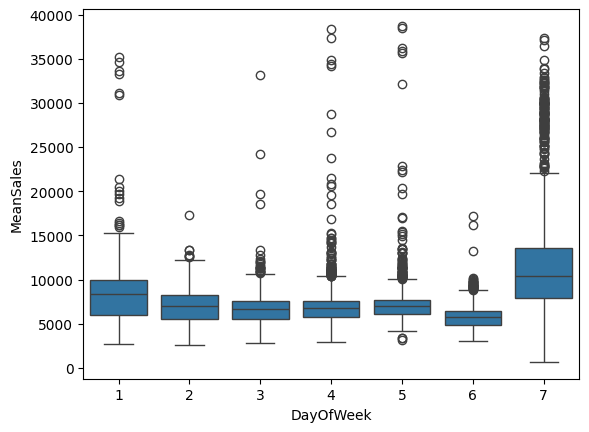

In [ ]:
sns.boxplot(x='DayOfWeek', y='MeanSales', data=soup_means_date_df)

<Axes: xlabel='DayOfWeek', ylabel='MeanCustomers'>

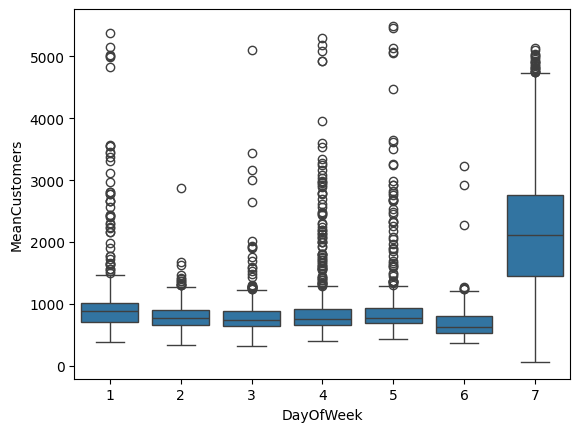

In [ ]:
sns.boxplot(x='DayOfWeek', y='MeanCustomers', data=soup_means_date_df)

<Axes: xlabel='DayOfWeek', ylabel='MeanCartValue'>

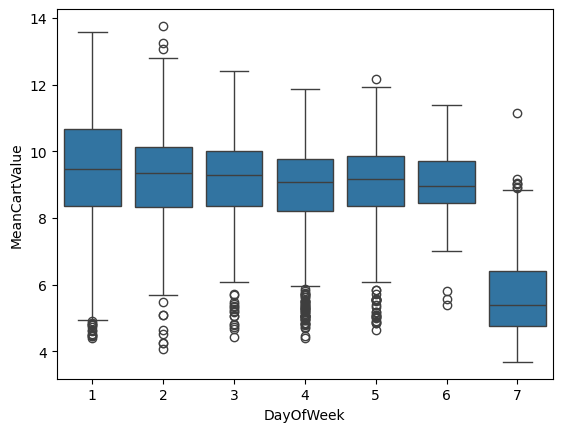

In [ ]:
sns.boxplot(x='DayOfWeek', y='MeanCartValue', data=soup_means_date_df)

As can be seen in the above graphs, the day of the week has an impact on sales, customers quantity and cart value. From the analysis of the graphs, we can also conclude that:
- at least some stores are open on Saturday and Sunday.
- on Monday, stores generate high sales and customers quantity, cart value is the highest (people mainly stock up on Mondays)
- on Saturday, stores generate low sales and have a few customers
- on Sunday, the sales and customers quantity is high but cart value is low (other competitive stores are probably closed and customers buy products they lack)

## Month phase influence analysis

<Axes: xlabel='MonthPhase', ylabel='MeanSales'>

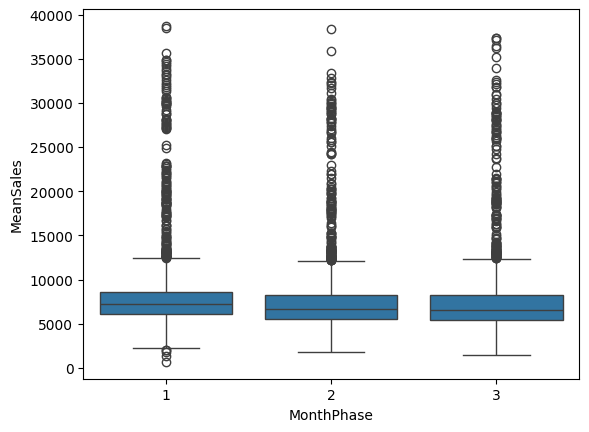

In [ ]:
sns.boxplot(x='MonthPhase', y='MeanSales', data=soup_means_date_df)

<Axes: xlabel='MonthPhase', ylabel='MeanCustomers'>

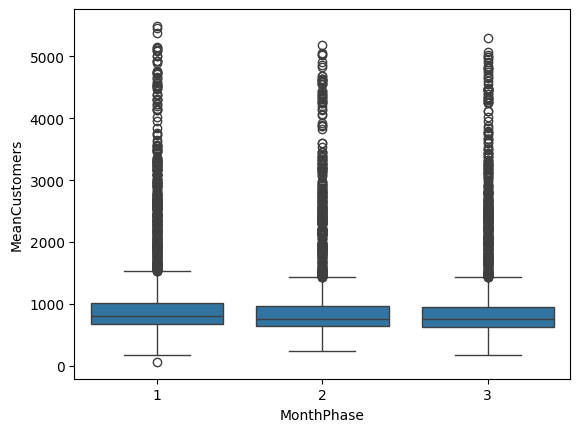

In [ ]:
sns.boxplot(x='MonthPhase', y='MeanCustomers', data=soup_means_date_df)

<Axes: xlabel='MonthPhase', ylabel='MeanCartValue'>

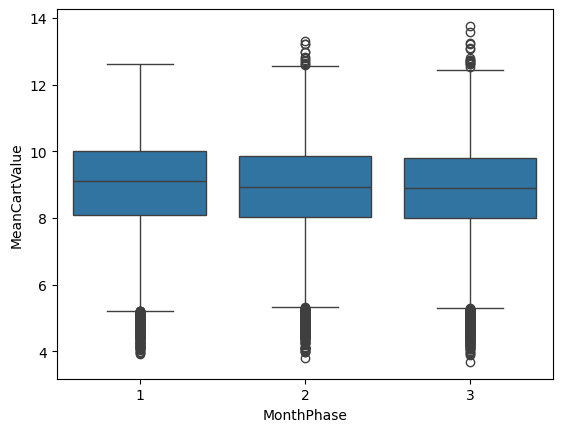

In [ ]:
sns.boxplot(x='MonthPhase', y='MeanCartValue', data=soup_means_date_df)

In [ ]:
# Compare phases in CartValue
create_hypotesis('CartValue', 'MonthPhase', soup_open_df, 0.05, 1, 3)
create_hypotesis('CartValue', 'MonthPhase', soup_open_df, 0.05, 1, 2)
create_hypotesis('CartValue', 'MonthPhase', soup_open_df, 0.05, 2, 3)

Test A/B MonthPhase
T-Statistic: 37.30342425419214
P-Value: 3.428551148572965e-304
There is a significant difference between MonthPhase == 1 and MonthPhase == 3.
Group MonthPhase == 1 is more effective than Group MonthPhase == 3
by 0.21843401629796233 mean. 

Test A/B MonthPhase
T-Statistic: 33.72820414482266
P-Value: 3.9986252691824463e-249
There is a significant difference between MonthPhase == 1 and MonthPhase == 2.
Group MonthPhase == 1 is more effective than Group MonthPhase == 2
by 0.19990643483848736 mean. 

Test A/B MonthPhase
T-Statistic: 3.199805198895473
P-Value: 0.00137527974664959
There is a significant difference between MonthPhase == 2 and MonthPhase == 3.
Group MonthPhase == 2 is more effective than Group MonthPhase == 3
by 0.018527581459474973 mean. 



The phase of the month affects the change in sales, customers quantity and cart value, which is proven by A/B tests, despite the fact that the change is barely noticeable in the case of sales and customers quantity on the charts. It is different in the case of the average cart value, where the first phase of the month stands out the most, which is probably related to the fact that in Germany, payouts are most often received on the last day of the month, which indicates that people are willing to spend more after payday.

The analysis between special offer, store type, assortment and month phase will be omitted due to the lack of correlation in the heatmap.

## Weather influence analysis

### Snow

<Axes: xlabel='Snow', ylabel='Sales'>

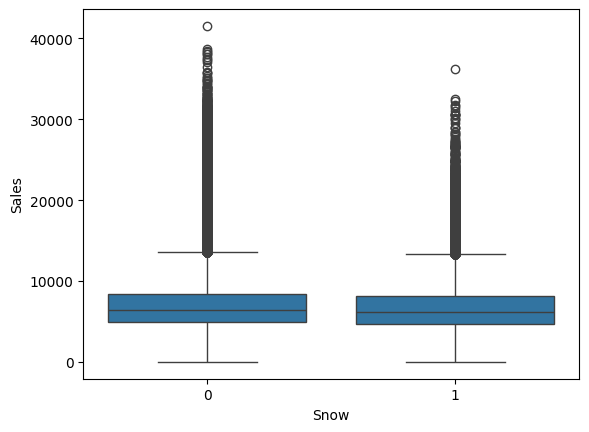

In [ ]:
sns.boxplot(x='Snow', y='Sales', data=soup_open_df)

<Axes: xlabel='Snow', ylabel='Customers'>

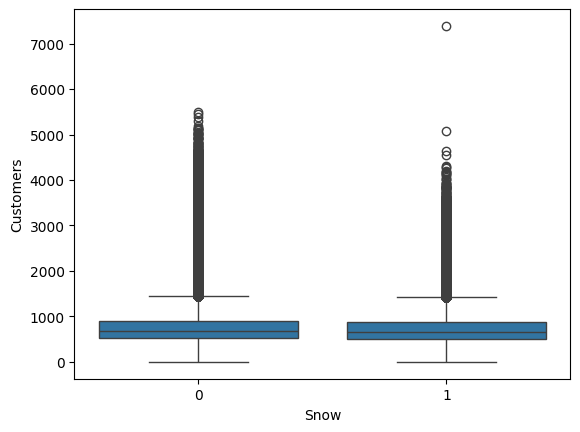

In [ ]:
sns.boxplot(x='Snow', y='Customers', data=soup_open_df)

<Axes: xlabel='Snow', ylabel='CartValue'>

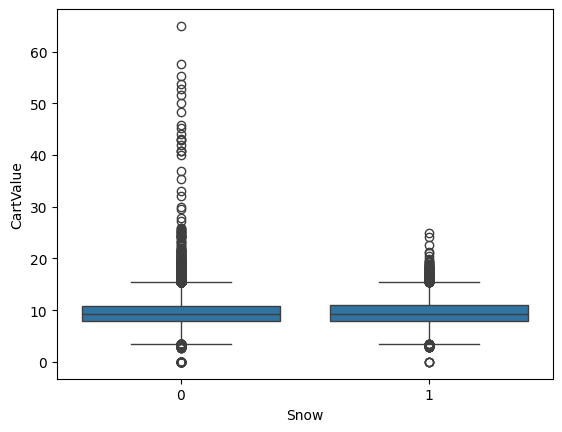

In [ ]:
sns.boxplot(x='Snow', y='CartValue', data=soup_open_df)

In [ ]:
create_hypotesis('Sales', 'Snow', soup_open_df)
create_hypotesis('Customers', 'Snow', soup_open_df)
create_hypotesis('CartValue', 'Snow', soup_open_df)

Test A/B Snow
T-Statistic: -21.683372374389837
P-Value: 3.1448967904291003e-104
There is a significant difference between Snow == 1 and Snow == 0.
Group Snow == 0 is more effective than Group Snow == 1.
by 244.2129400913982 mean. 

Test A/B Snow
T-Statistic: -22.360654373704435
P-Value: 1.0244213647847394e-110
There is a significant difference between Snow == 1 and Snow == 0.
Group Snow == 0 is more effective than Group Snow == 1.
by 32.55051153677937 mean. 

Test A/B Snow
T-Statistic: 6.892535930112354
P-Value: 5.484460479058635e-12
There is a significant difference between Snow == 1 and Snow == 0.
Group Snow == 1 is more effective than Group Snow == 0
by 0.05499733210309188 mean. 



Snow affects sales, customers quantity and cart value, as proven by A/B tests. Despite this, the difference is so small that it is not worth taking into account when creating a model.

### Rain

<Axes: xlabel='Rain', ylabel='Sales'>

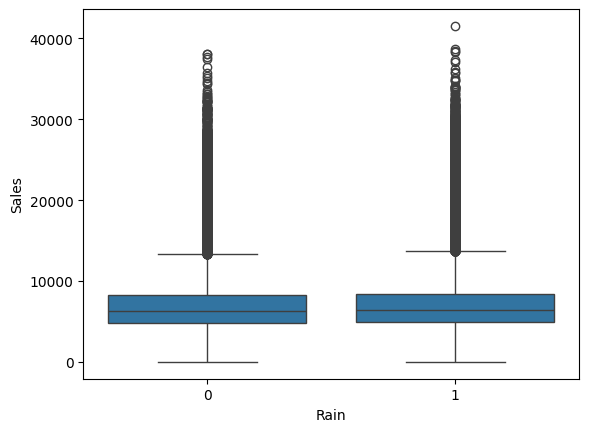

In [ ]:
sns.boxplot(x='Rain', y='Sales', data=soup_open_df)

<Axes: xlabel='Rain', ylabel='Customers'>

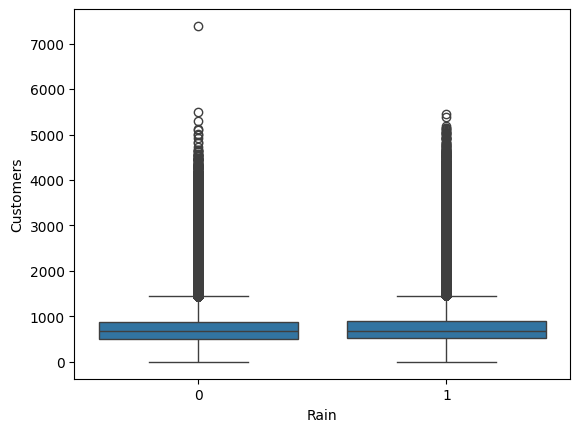

In [ ]:
sns.boxplot(x='Rain', y='Customers', data=soup_open_df)

<Axes: xlabel='Rain', ylabel='CartValue'>

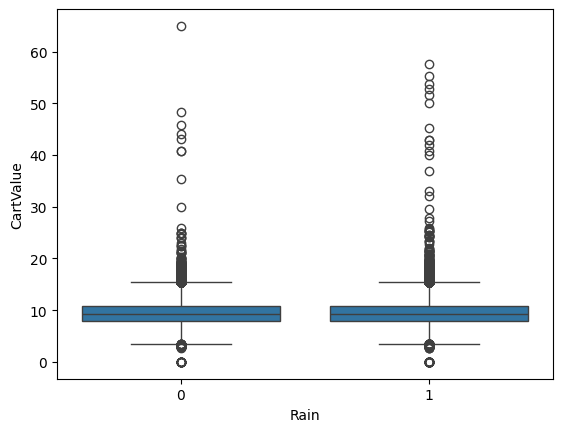

In [ ]:
sns.boxplot(x='Rain', y='CartValue', data=soup_open_df)

In [ ]:
create_hypotesis('Sales', 'Rain', soup_open_df)
create_hypotesis('Customers', 'Rain', soup_open_df)
create_hypotesis('CartValue', 'Rain', soup_open_df)

Test A/B Rain
T-Statistic: 17.87800073597596
P-Value: 1.8040735660501442e-71
There is a significant difference between Rain == 1 and Rain == 0.
Group Rain == 1 is more effective than Group Rain == 0
by 122.5189283984746 mean. 

Test A/B Rain
T-Statistic: 12.60526130994519
P-Value: 1.9901730978720932e-36
There is a significant difference between Rain == 1 and Rain == 0.
Group Rain == 1 is more effective than Group Rain == 0
by 11.166486530276984 mean. 

Test A/B Rain
T-Statistic: 1.8649202649253793
P-Value: 0.06219292807307233
There is no significant difference between Rain == 1 and Rain == 0. 



Rain affects sales and customers quantity, which is proven by A/B tests, but does not affect the value of the basket. Despite this, the difference is so small that it is not worth taking into account when creating a model.

### Thunderstorm

<Axes: xlabel='Thunderstorm', ylabel='Sales'>

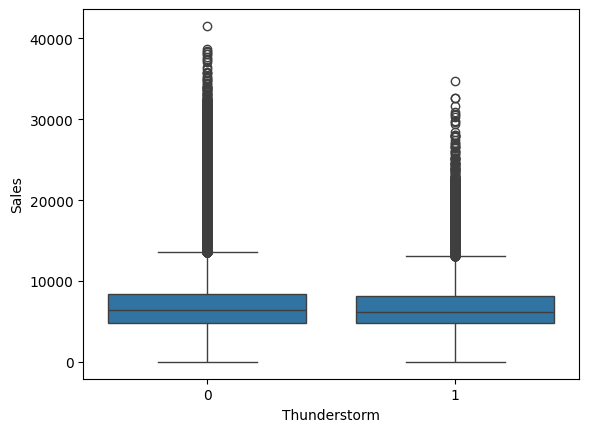

In [ ]:
sns.boxplot(x='Thunderstorm', y='Sales', data=soup_open_df)

<Axes: xlabel='Thunderstorm', ylabel='Customers'>

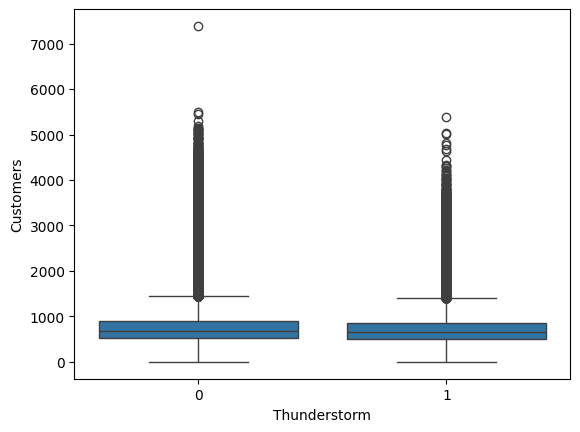

In [ ]:
sns.boxplot(x='Thunderstorm', y='Customers', data=soup_open_df)

<Axes: xlabel='Thunderstorm', ylabel='CartValue'>

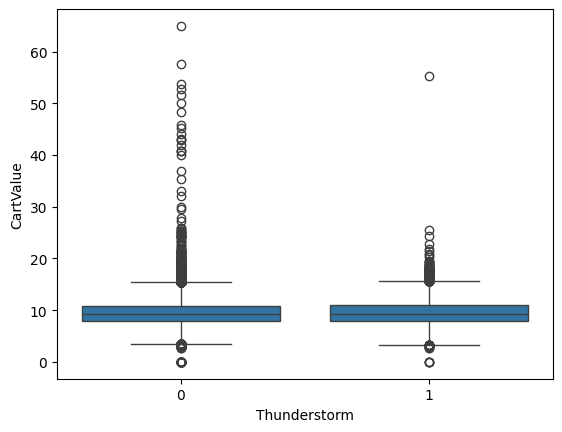

In [ ]:
sns.boxplot(x='Thunderstorm', y='CartValue', data=soup_open_df)

In [ ]:
create_hypotesis('Sales', 'Thunderstorm', soup_open_df)
create_hypotesis('Customers', 'Thunderstorm', soup_open_df)
create_hypotesis('CartValue', 'Thunderstorm', soup_open_df)

Test A/B Thunderstorm
T-Statistic: -13.898163722122911
P-Value: 6.571655680582803e-44
There is a significant difference between Thunderstorm == 1 and Thunderstorm == 0.
Group Thunderstorm == 0 is more effective than Group Thunderstorm == 1.
by 193.56239680867202 mean. 

Test A/B Thunderstorm
T-Statistic: -9.901998140273296
P-Value: 4.092264383259344e-23
There is a significant difference between Thunderstorm == 1 and Thunderstorm == 0.
Group Thunderstorm == 0 is more effective than Group Thunderstorm == 1.
by 17.82583961634566 mean. 

Test A/B Thunderstorm
T-Statistic: 0.44327251531589057
P-Value: 0.6575687468183911
There is no significant difference between Thunderstorm == 1 and Thunderstorm == 0. 



The storm sales and customers quantity, which is proven by A/B tests, but does not affect the value of the basket. Despite this, the difference is so small that it is not worth taking into account when creating a model.

### Fog

<Axes: xlabel='Fog', ylabel='Sales'>

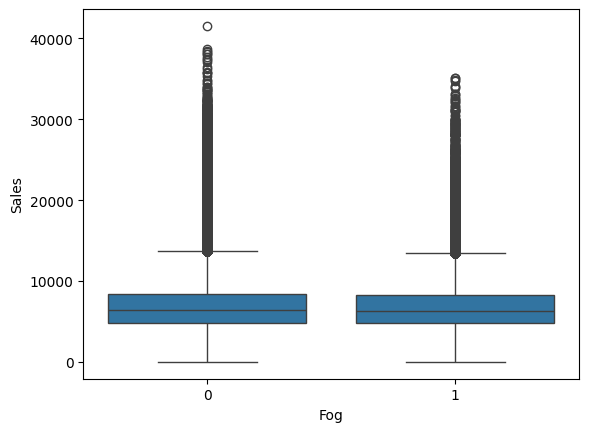

In [ ]:
sns.boxplot(x='Fog', y='Sales', data=soup_open_df)

<Axes: xlabel='Fog', ylabel='Customers'>

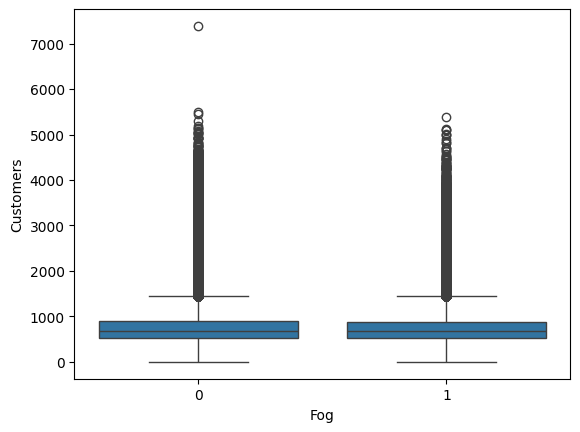

In [ ]:
sns.boxplot(x='Fog', y='Customers', data=soup_open_df)

<Axes: xlabel='Fog', ylabel='CartValue'>

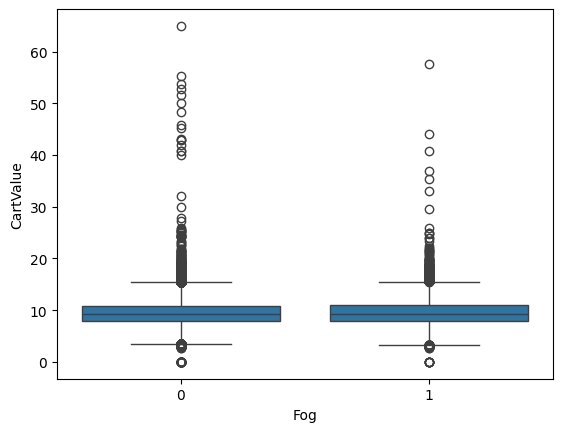

In [ ]:
sns.boxplot(x='Fog', y='CartValue', data=soup_open_df)

In [ ]:
create_hypotesis('Fog', 'Hail', soup_open_df)
create_hypotesis('Fog', 'Hail', soup_open_df)
create_hypotesis('Fog', 'Hail', soup_open_df)

Test A/B Hail
T-Statistic: -13.818236751252146
P-Value: 2.0002665451825014e-43
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 0 is more effective than Group Hail == 1.
by 0.06597990063452613 mean. 

Test A/B Hail
T-Statistic: -13.818236751252146
P-Value: 2.0002665451825014e-43
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 0 is more effective than Group Hail == 1.
by 0.06597990063452613 mean. 

Test A/B Hail
T-Statistic: -13.818236751252146
P-Value: 2.0002665451825014e-43
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 0 is more effective than Group Hail == 1.
by 0.06597990063452613 mean. 



Fog affects sales, customers quantity and cart value, as proven by A/B tests. Despite this, the difference is so small that it is not worth taking into account when creating a model.

### Hail

<Axes: xlabel='Hail', ylabel='Sales'>

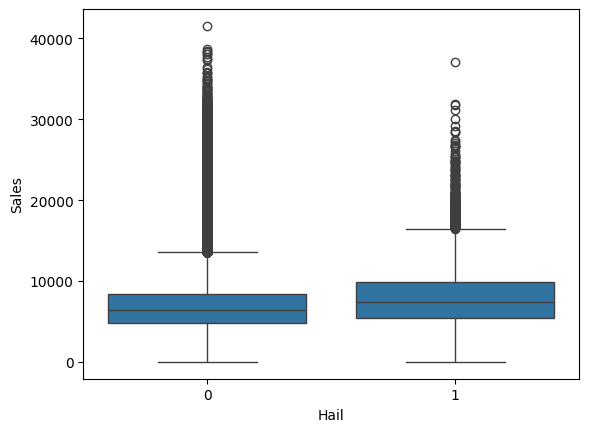

In [ ]:
sns.boxplot(x='Hail', y='Sales', data=soup_open_df)

<Axes: xlabel='Hail', ylabel='Customers'>

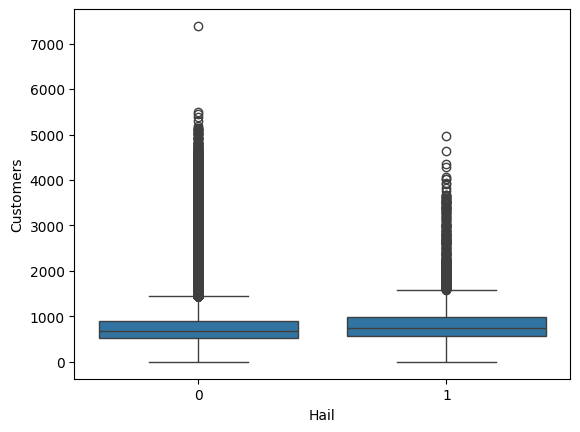

In [ ]:
sns.boxplot(x='Hail', y='Customers', data=soup_open_df)

<Axes: xlabel='Hail', ylabel='CartValue'>

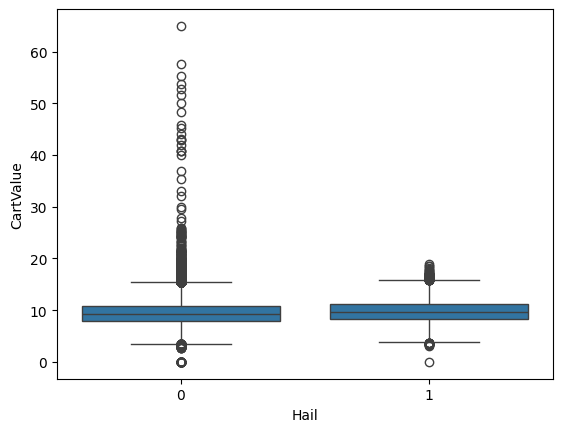

In [ ]:
sns.boxplot(x='Hail', y='CartValue', data=soup_open_df)

In [ ]:
create_hypotesis('Sales', 'Hail', soup_open_df)
create_hypotesis('Customers', 'Hail', soup_open_df)
create_hypotesis('CartValue', 'Hail', soup_open_df)

Test A/B Hail
T-Statistic: 32.409196516573836
P-Value: 2.8246083094583217e-230
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 1 is more effective than Group Hail == 0
by 1124.3950378059299 mean. 

Test A/B Hail
T-Statistic: 18.059318781600645
P-Value: 6.878461462569204e-73
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 1 is more effective than Group Hail == 0
by 81.01720260996728 mean. 

Test A/B Hail
T-Statistic: 14.816915944428606
P-Value: 1.1554649299374636e-49
There is a significant difference between Hail == 1 and Hail == 0.
Group Hail == 1 is more effective than Group Hail == 0
by 0.3642789268538582 mean. 



Hail has a positive effect on the sales, customers quantity and cart value, as evidenced by A/B tests and boxplots. The change is significant, so a suggested explanation may be that the items offered by these stores may be replacements for items damaged by hail, are outside and are urgently needed, e.g. car parts, windows, roofing, satellite dishes.

#### Hail influence dependency on store and assortment type

<Axes: xlabel='StoreType', ylabel='CartValue'>

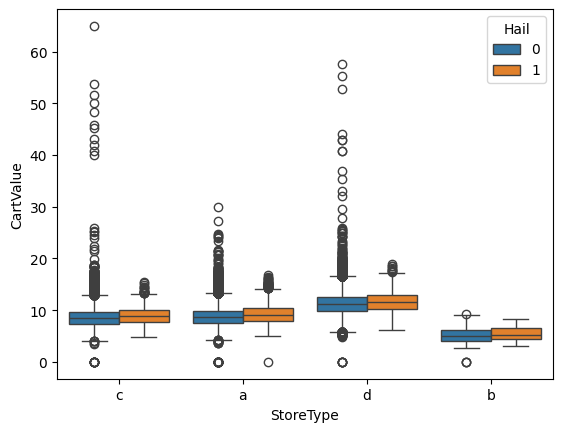

In [ ]:
sns.boxplot(x="StoreType", y="CartValue", hue="Hail", dodge=True, data=soup_open_df)

<Axes: xlabel='Assortment', ylabel='CartValue'>

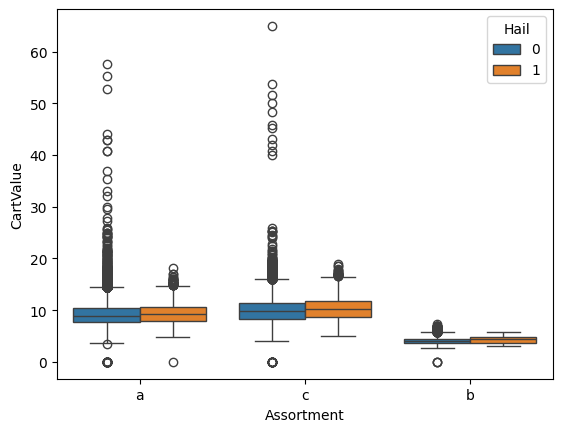

In [ ]:
sns.boxplot(x="Assortment", y="CartValue", hue="Hail", dodge=True, data=soup_open_df)

No correlation was observed between hail and store or assortment type.

## Months influence analysis

<Axes: xlabel='Month', ylabel='MeanSales'>

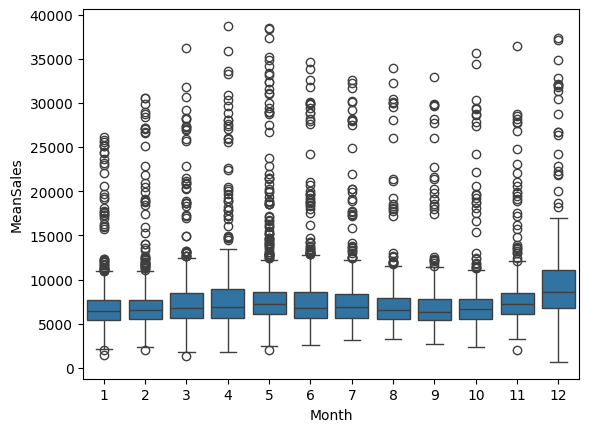

In [ ]:
sns.boxplot(x='Month', y='MeanSales', data=soup_means_date_df)

<Axes: xlabel='Month', ylabel='MeanCustomers'>

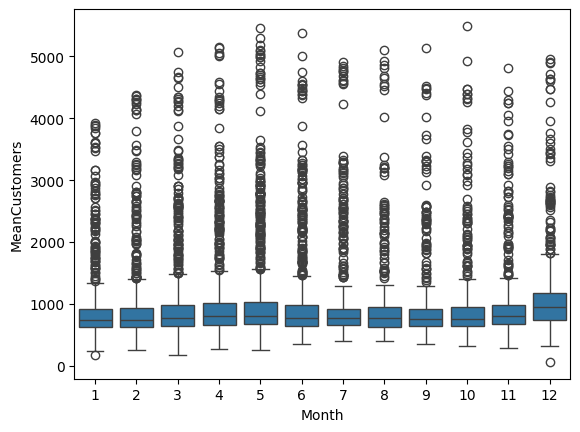

In [ ]:
sns.boxplot(x='Month', y='MeanCustomers', data=soup_means_date_df)

<Axes: xlabel='Month', ylabel='MeanCartValue'>

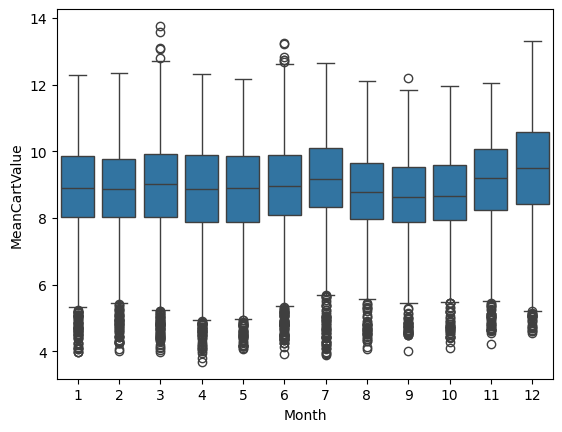

In [ ]:
sns.boxplot(x='Month', y='MeanCartValue', data=soup_means_date_df)

As can be seen in the above graphs, the value of business coefficients varies significantly depending on the month.
- December is the month of the highest sales, customers quantity and cart value, which is related to Christmas
- June and July, the high cart value and low customers quantity may be related to the arrival of tourists and their greater willingness to buy more expensive products and the outflow of the native population.

## States influence analysis

<Axes: xlabel='State', ylabel='MeanSales'>

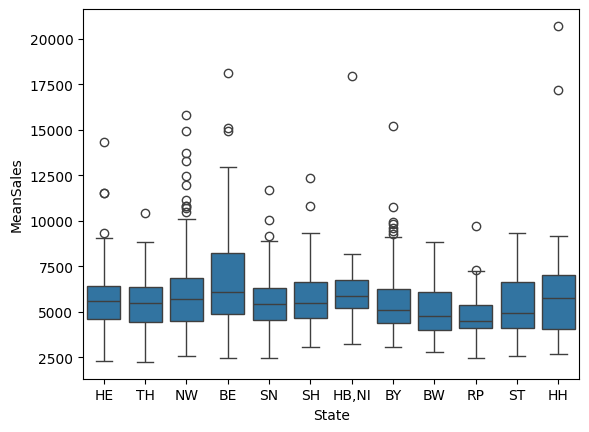

In [ ]:
sns.boxplot(x='State', y='MeanSales', data=soup_means_df)

<Axes: xlabel='State', ylabel='MeanCustomers'>

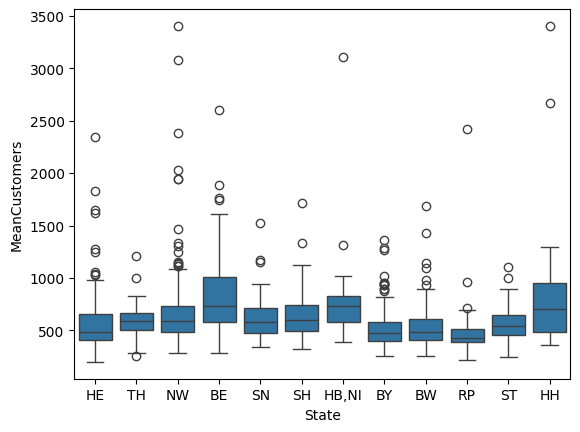

In [ ]:
sns.boxplot(x='State', y='MeanCustomers', data=soup_means_df)

<Axes: xlabel='State', ylabel='MeanCartValue'>

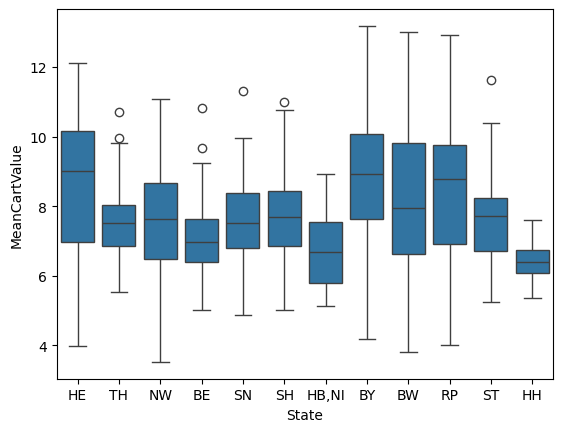

In [ ]:
sns.boxplot(x='State', y='MeanCartValue', data=soup_means_df)

From the analysis of the above charts, it follows that the state has a significant impact on sales, customers quantity, and cart value. More specific information is presented below:

Sales:
  - The highest value is associated with the state of Berlin.
  - The lowest value is associated with the state of Rheinland-Pfalz.

- Customers quantity:
  - The highest values are associated with the states of Berlin and Niedersachsen.
  - The lowest value is associated with the state of Rheinland-Pfalz.

- Cart value:
  - The highest value is associated with the state of Hessen.
  - The lowest value is associated with the state of Hamburg.

Apart from these, the values vary greatly, and it is difficult at this moment to understand the relationships between them.


### Check dependency between states and stores types

<Axes: xlabel='State', ylabel='MeanSales'>

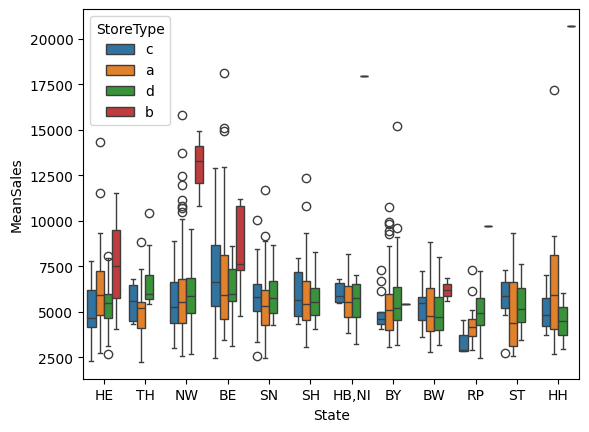

In [ ]:
sns.boxplot(x='State', y='MeanSales', hue='StoreType', data=soup_means_df)

Apart from the fact that shop b has the highest sales of all shops, it is difficult to notice any other significant relationships. Practically each state generates different turnover for each type of shop.

<Axes: xlabel='State', ylabel='MeanCustomers'>

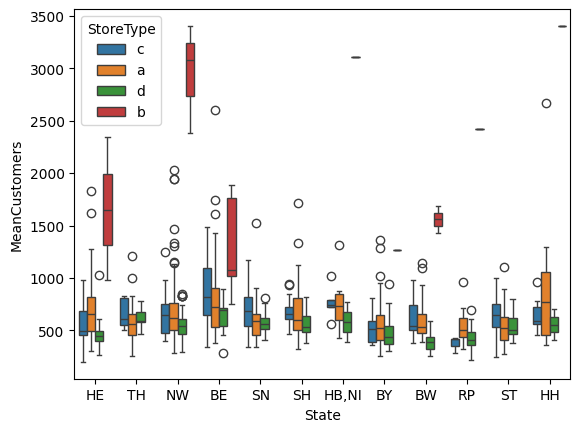

In [ ]:
sns.boxplot(x='State', y='MeanCustomers', hue='StoreType', data=soup_means_df)

Conclusions:
- type a store has more customers than c in the states:
    - Hessen (HE)
    - Bayern (BY)
    - RheinlandPfalz (RP)
- Hamburg (HH)
    - type b stores have the highest customers quantity everywhere
    - type d stores are more popular than b in the state:
- Thueringen (TH)


<Axes: xlabel='State', ylabel='MeanCartValue'>

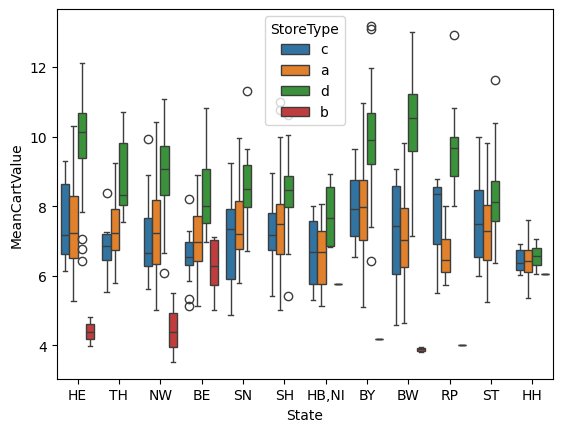

In [ ]:
sns.boxplot(x='State', y='MeanCartValue', hue='StoreType', data=soup_means_df)

Conclusions:
- type d stores have the highest cart value everywhere
- type b stores have the lowest cart value everywhere
- type c stores have a significantly higher cart value than type a stores in the states:
    - Sachsen (SN)
    - Baden-Wuerttemberg (BW)
    - Rheinland-Pfalz (RP)
    - Sachsen-Anhalt (ST)

### Check dependency between states and assortment

<Axes: xlabel='State', ylabel='MeanSales'>

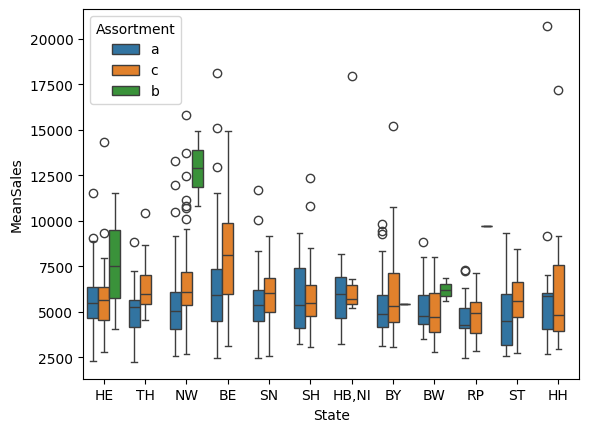

In [ ]:
sns.boxplot(x='State', y='MeanSales', hue='Assortment', data=soup_means_df)

Only in the states of Niedersachsen (HB,IN), Baden Wuerttemberg (BW), Hamburg (HH) does the assortment c generate less sales than the assortment a

<Axes: xlabel='State', ylabel='MeanCustomers'>

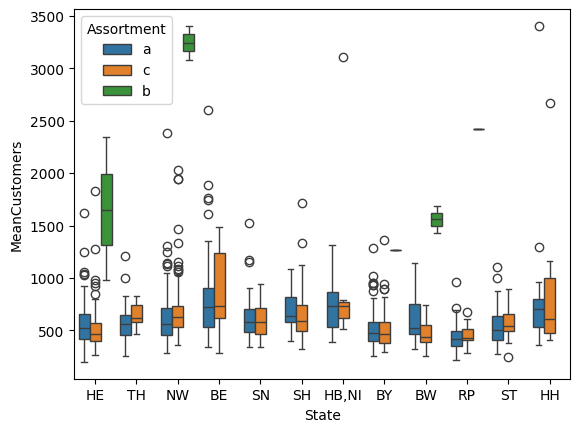

In [ ]:
sns.boxplot(x='State', y='MeanCustomers', hue='Assortment', data=soup_means_df)

Shops with assortment a have more customers than all others in the areas:
- Schleswig-Holstein (SH)
- Bayern (BY)
- Baden-Wuerttemberg (BW)
- Hamburg (HH)

<Axes: xlabel='State', ylabel='MeanCartValue'>

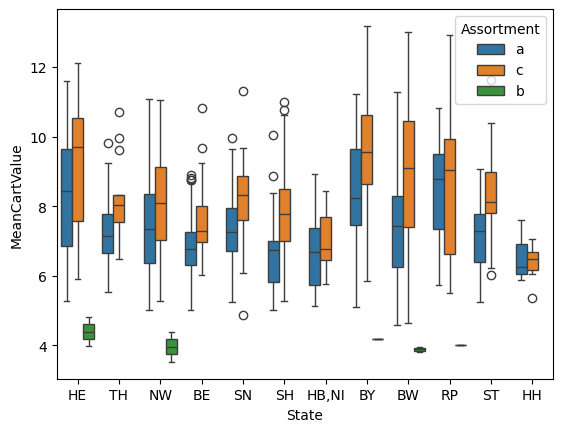

In [ ]:
sns.boxplot(x='State', y='MeanCartValue', hue='Assortment', data=soup_means_df)

Check dependency between states and school-free days

<Axes: xlabel='State', ylabel='MeanSales'>

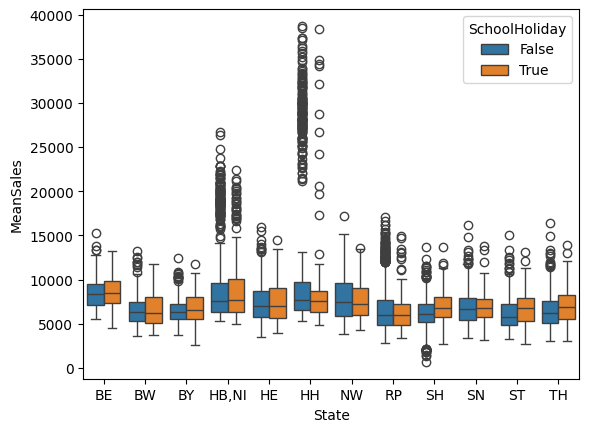

In [ ]:
sns.boxplot(x='State', y='MeanSales', hue='SchoolHoliday', data=soup_means_date_df)

Sales in NordrheinWestfalen (NW), Hamburg (HH), Baden-Wuerttemberg (BW) during school holidays is lower than on school days compared to the other states which are either comparable or higher.

<Axes: xlabel='State', ylabel='MeanCustomers'>

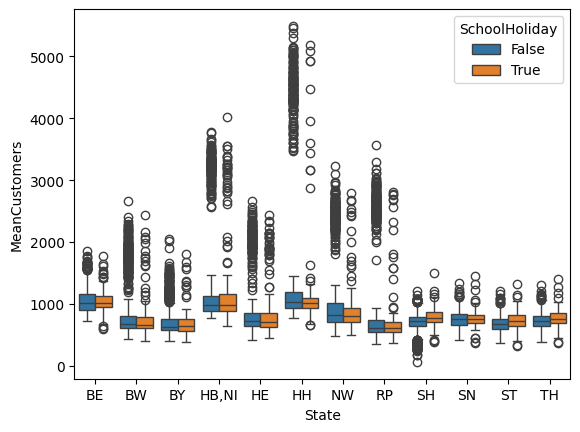

In [ ]:
sns.boxplot(x='State', y='MeanCustomers', hue='SchoolHoliday', data=soup_means_date_df)

In the states of Schleswig-Holstein (SH), Sachsen-Anhalt (SA), Thueringen (TH) customers quantity is significantly higher than on school days compared to the other states which are either comparable or lower.

<Axes: xlabel='State', ylabel='MeanCartValue'>

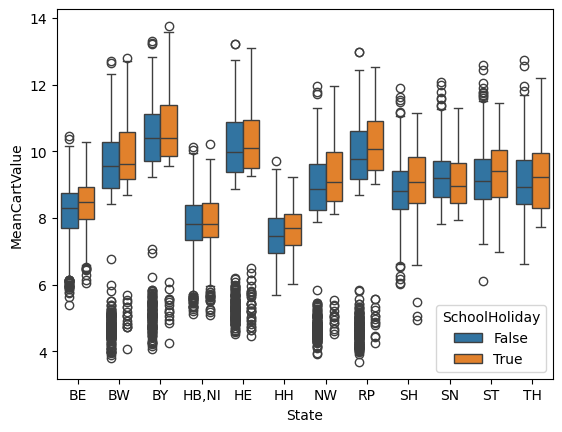

In [ ]:
sns.boxplot(x='State', y='MeanCartValue', hue='SchoolHoliday', data=soup_means_date_df)

In the state of Sachsen (SN), the cart value drops significantly during school holidays compared to all other states.

# Phase II Model

Preparation of important data

In [ ]:
important_columns = ['StoreType', 'Assortment', 'Promo', 'MonthPhase', 'Month', 'Hail', 'DayOfWeek']
func = f'Sales ~ { " + ".join([f"C({x})" for x in important_columns]) }'
soup_important_df = soup_open_df.groupby(important_columns + ['Date']).agg({'Sales': 'mean'}).reset_index()

Creating a complete model

In [ ]:
model_full = ols(func, data=soup_important_df)
model_full_estimation = model_full.fit()
print(model_full_estimation.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     1046.
Date:                Sat, 27 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:11:56   Log-Likelihood:                -74157.
No. Observations:                8214   AIC:                         1.484e+05
Df Residuals:                    8187   BIC:                         1.486e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           5178.5609    111

Conclusions:
- A satisfactory model of 0.769 R-Squared was obtained

Comparison of predictions from a limited set on real data

                            OLS Regression Results                            
Dep. Variable:              SalesReal   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     105.4
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           1.99e-25
Time:                        00:11:56   Log-Likelihood:                -3206.0
No. Observations:                 538   AIC:                             7428.
Df Residuals:                      30   BIC:                             9606.
Df Model:                         507                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

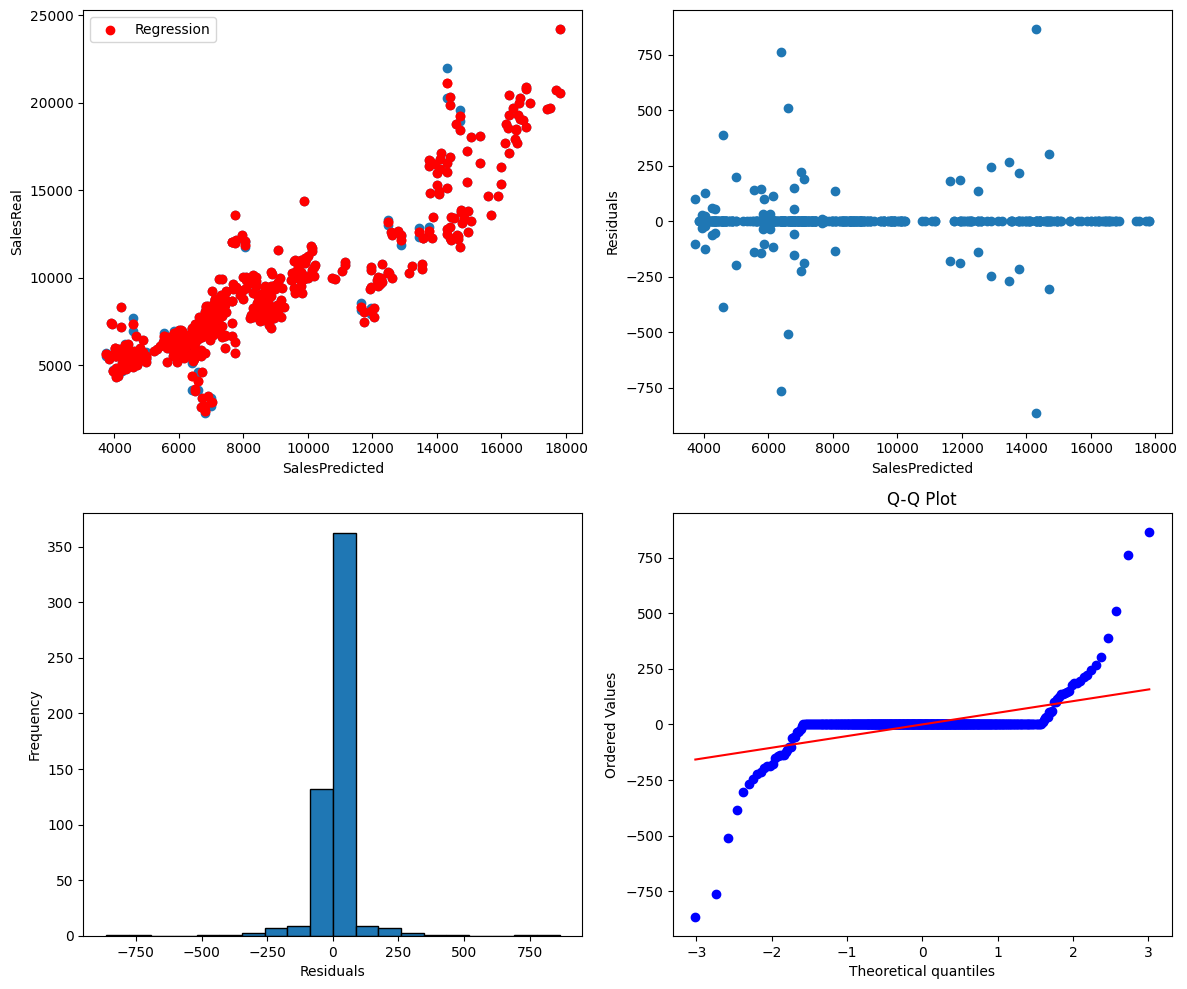

In [ ]:
soup_important_train_df = soup_important_df[(
(soup_important_df['Date'].dt.year <= 2014) &
(soup_important_df['Date'].dt.month.between(6, 7)))
].copy()

soup_important_test_df = soup_important_df[
(soup_important_df['Date'].dt.year == 2015) &
(soup_important_df['Date'].dt.month.between(6, 7))
].copy()


model_train_pred = ols(func, data=soup_important_train_df)
train_estimation = model_train_pred.fit()

soup_important_test_df_without_sales = soup_important_test_df.drop('Sales', axis=1)

predicted_sales = train_estimation.predict(soup_important_test_df_without_sales)

compare_df = pd.DataFrame()
compare_df['SalesPredicted'] = predicted_sales
compare_df['SalesReal'] = soup_important_test_df['Sales']

residual_analysis(compare_df, 'SalesPredicted', 'SalesReal')


Conclusions
- we managed to obtain a prediction at a satisfactory level of 0.999 of the R-Squared result
- adding the State/StateName factor significantly reduces the results